# Taller de Opciones SPY - MIAX 14 Emilio Sánchez

## 

---

# ═══════════════════════════════════════════════════════════════
# PARTE 1: Conexión y fundamentos de opciones
# ═══════════════════════════════════════════════════════════════

## 1.1 Conexión a Broker desde Python

Configuramos el entorno y conectamos a Interactive Brokers para obtener datos en tiempo real. Usamos datos frozen (delayed) con marketDataType=4.

In [ ]:
# ============================================================
# CONFIGURACIÓN INICIAL - CONEXIÓN A IBKR
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import griddata, UnivariateSpline
from scipy.optimize import brentq
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from ib_insync import IB, Stock, Option, util, MarketOrder, LimitOrder, ComboLeg, Contract
util.startLoop()

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

# Parámetros globales
SIMBOLO = "SPY"
r = 0.045
q = 0.013

# ============================================================
# CONEXIÓN A IBKR
# ============================================================

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)  # 7497=Paper, 7496=Live

# Usar datos frozen (delayed) - marketDataType 4
ib.reqMarketDataType(4)

print(f"[OK] Conectado a IBKR")
print(f"  Cuentas: {ib.managedAccounts()}")
print(f"  Usando datos: FROZEN (delayed)")

# Obtener spot de SPY
spy_stock = Stock(SIMBOLO, 'SMART', 'USD')
ib.qualifyContracts(spy_stock)

ticker_spy = ib.reqMktData(spy_stock, '', False, False)
ib.sleep(2)  # Esperar a que lleguen los datos

# Usar el precio disponible (last, close, o bid/ask mid)
if ticker_spy.last and ticker_spy.last > 0:
    spot = ticker_spy.last
elif ticker_spy.close and ticker_spy.close > 0:
    spot = ticker_spy.close
elif ticker_spy.bid and ticker_spy.ask:
    spot = (ticker_spy.bid + ticker_spy.ask) / 2
else:
    raise ValueError("No se pudo obtener el precio de SPY")

ib.cancelMktData(spy_stock)

print(f"\n[OK] Spot SPY: ${spot:.2f}")

[OK] Conectado a IBKR
  Cuentas: ['DUM355962']
  Usando datos: FROZEN (delayed)

[OK] Spot SPY: $694.02


Error 200, reqId 102: No security definition has been found for the request, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=721.0, right='C', exchange='SMART')
Error 200, reqId 103: No security definition has been found for the request, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=722.0, right='C', exchange='SMART')
Error 200, reqId 104: No security definition has been found for the request, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=723.0, right='C', exchange='SMART')
Error 200, reqId 105: No security definition has been found for the request, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=724.0, right='C', exchange='SMART')
Error 200, reqId 107: No security definition has been found for the request, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=726.0, right='C', exchange='SMART')
Error 200, reqId 108: No security defini

## 1.2 Obtener Cadena de Opciones (Option Chain)

Obtenemos la cadena de opciones de SPY para múltiples vencimientos usando Interactive Brokers. Extraemos strikes, precios y datos necesarios para calcular la volatilidad implícita.

In [24]:
# ============================================================
# FUNCIONES BASE (del notebook original)
# ============================================================

def black_scholes(S, K, T, r, sigma, q=0, tipo='C'):
    if T <= 0:
        return max(S - K, 0) if tipo == 'C' else max(K - S, 0)
    if sigma <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if tipo == 'C':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def calcular_griegas(S, K, T, r, sigma, q=0, tipo='C'):
    if T <= 0 or sigma <= 0:
        return {'delta': np.nan, 'gamma': np.nan, 'theta': np.nan, 'vega': np.nan, 'rho': np.nan}
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sqrt_T = np.sqrt(T)
    exp_qT = np.exp(-q * T)
    exp_rT = np.exp(-r * T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    n_d1 = norm.pdf(d1)
    
    if tipo == 'C':
        delta = exp_qT * N_d1
    else:
        delta = -exp_qT * norm.cdf(-d1)
    
    gamma = (exp_qT * n_d1) / (S * sigma * sqrt_T)
    theta_base = -(S * exp_qT * n_d1 * sigma) / (2 * sqrt_T)
    if tipo == 'C':
        theta = theta_base + q * S * exp_qT * N_d1 - r * K * exp_rT * N_d2
    else:
        theta = theta_base - q * S * exp_qT * norm.cdf(-d1) + r * K * exp_rT * norm.cdf(-d2)
    theta_diario = theta / 365
    vega = S * exp_qT * n_d1 * sqrt_T / 100
    if tipo == 'C':
        rho = K * T * exp_rT * N_d2 / 100
    else:
        rho = -K * T * exp_rT * norm.cdf(-d2) / 100
    
    return {'delta': delta, 'gamma': gamma, 'theta': theta_diario, 'vega': vega, 'rho': rho}

def implied_vol_biseccion(precio_mercado, S, K, T, r, q, tipo, tol=1e-6):
    if T <= 0 or precio_mercado <= 0:
        return np.nan
    def objetivo(sigma):
        return black_scholes(S, K, T, r, sigma, q, tipo) - precio_mercado
    try:
        return brentq(objetivo, 0.001, 3.0, xtol=tol)
    except:
        return np.nan

print("[OK] Funciones base cargadas")

[OK] Funciones base cargadas


In [25]:
# ============================================================
# CONSTRUIR SUPERFICIE DE VOLATILIDAD (CORREGIDO)
# ============================================================

from datetime import datetime, timedelta
import pandas as pd
from ib_insync import Option  # Asegurar importación

print("Obteniendo cadena de opciones desde IBKR...")

# 1. Obtener parámetros de opciones (SecDefOptParams)
chains = ib.reqSecDefOptParams(spy_stock.symbol, '', spy_stock.secType, spy_stock.conId)

if not chains:
    raise ValueError("No se pudieron obtener los parámetros de opciones")

# 2. AGREGACIÓN: Unir todos los strikes y vencimientos de todas las cadenas SMART
# IBKR fragmenta los datos (weeklies, monthlies, etc.), hay que unirlos.
all_expirations = set()
all_strikes = set()

for c in chains:
    if c.exchange == 'SMART':
        all_expirations.update(c.expirations)
        all_strikes.update(c.strikes)

# Convertir a listas ordenadas
vencimientos_disponibles = sorted(list(all_expirations))
strikes_totales = sorted(list(all_strikes))

print(f"Exchange: SMART (Agregado)")
print(f"Vencimientos disponibles: {len(vencimientos_disponibles)}")
print(f"Strikes disponibles: {len(strikes_totales)}")

# 3. Seleccionar ~6 vencimientos espaciados
hoy = datetime.now()
fechas_objetivo = [hoy + timedelta(days=d) for d in [7, 14, 30, 60, 90, 120]]

vencimientos_seleccionados = []

if not vencimientos_disponibles:
    raise ValueError("No se encontraron vencimientos en SMART.")

for fecha_obj in fechas_objetivo:
    fecha_str = fecha_obj.strftime('%Y%m%d')
    # Encontrar el vencimiento más cercano en la lista agregada
    mejor = min(vencimientos_disponibles, 
                key=lambda x: abs(datetime.strptime(x, '%Y%m%d') - fecha_obj))
    if mejor not in vencimientos_seleccionados:
        vencimientos_seleccionados.append(mejor)

print(f"\nVencimientos seleccionados: {vencimientos_seleccionados}")

# 4. Filtrar strikes cercanos al spot (±10%)
RANGO_PCT = 0.10
strike_min = spot * (1 - RANGO_PCT)
strike_max = spot * (1 + RANGO_PCT)

# Usamos la lista agregada 'strikes_totales'
strikes_filtrados = [s for s in strikes_totales if strike_min <= s <= strike_max]

print(f"Strikes en rango ({strike_min:.0f} - {strike_max:.0f}): {len(strikes_filtrados)}")

if len(strikes_filtrados) == 0:
    print("ALERTA: No hay strikes en el rango. Revisa si la variable 'spot' es correcta.")

# 5. Recolectar datos de opciones
datos_superficie = []

for venc in vencimientos_seleccionados:
    fecha_venc = datetime.strptime(venc, '%Y%m%d')
    T = (fecha_venc - hoy).days / 365
    
    if T <= 0:
        continue
    
    print(f"  Procesando vencimiento {venc} (T={T*365:.0f} días)...")
    
    # Crear contratos de opciones para este vencimiento
    contratos_call = []
    for strike in strikes_filtrados:
        # Nota: Al no especificar tradingClass, qualifyContracts resolverá la más líquida/estándar
        contrato = Option(spy_stock.symbol, venc, strike, 'C', 'SMART')
        contratos_call.append(contrato)
    
    # Calificar contratos en batch
    contratos_calificados = ib.qualifyContracts(*contratos_call)
    
    # Solicitar datos de mercado
    tickers = []
    for contrato in contratos_calificados:
        if contrato.conId:
            # Snapshot=False para streaming (como en tu código original), luego esperamos
            ticker = ib.reqMktData(contrato, '', False, False)
            tickers.append((contrato, ticker))
    
    ib.sleep(3)  # Esperar a que se llenen los buffers de datos
    
    # Procesar datos
    puntos_vencimiento = 0
    for contrato, ticker in tickers:
        # Usamos bid/ask si existen, si no, intentamos last o close si el mercado está cerrado
        bid = ticker.bid if ticker.bid and ticker.bid > 0 else None
        ask = ticker.ask if ticker.ask and ticker.ask > 0 else None
        
        if bid and ask and bid < ask:
            mid = (bid + ask) / 2
            strike = contrato.strike
            
            # Calcular IV
            try:
                iv = implied_vol_biseccion(mid, spot, strike, T, r, q, 'C')
                
                if pd.notna(iv) and 0.05 < iv < 1.0: # Filtro de cordura para IV
                    datos_superficie.append({
                        'strike': strike,
                        'T': T,
                        'iv': iv * 100,
                        'moneyness': strike / spot,
                        'bid': bid,
                        'ask': ask,
                        'mid': mid,
                        'expiration': venc
                    })
                    puntos_vencimiento += 1
            except Exception as e:
                pass # Ignorar errores de cálculo en puntos individuales
        
        # Cancelar suscripción para no saturar
        ib.cancelMktData(contrato)
    
    print(f"    -> {puntos_vencimiento} puntos válidos recolectados.")

df_superficie = pd.DataFrame(datos_superficie)
print(f"\n[OK] TOTAL Puntos recolectados: {len(df_superficie)}")

if len(df_superficie) > 0:
    print(f"  Rango IV: {df_superficie['iv'].min():.1f}% - {df_superficie['iv'].max():.1f}%")
    print(f"  Rango strikes: ${df_superficie['strike'].min():.0f} - ${df_superficie['strike'].max():.0f}")
else:
    print("  No se recolectaron datos. Verifica si el mercado está abierto o si tienes suscripción de datos.")

Obteniendo cadena de opciones desde IBKR...
Exchange: SMART (Agregado)
Vencimientos disponibles: 35
Strikes disponibles: 430

Vencimientos seleccionados: ['20260120', '20260126', '20260213', '20260312', '20260417', '20260430']
Strikes en rango (625 - 763): 128
  Procesando vencimiento 20260120 (T=7 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=721.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=722.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=723.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=724.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=726.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=727.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=728.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260120', strike=729.0, right='C', exchange='SMART')
Unknown contract

    -> 71 puntos válidos recolectados.
  Procesando vencimiento 20260126 (T=13 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=626.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=627.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=628.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=629.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=631.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=632.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=633.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260126', strike=634.0, right='C', exchange='SMART')
Unknown contract

    -> 28 puntos válidos recolectados.
  Procesando vencimiento 20260213 (T=31 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=626.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=627.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=628.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=629.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=631.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=632.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=633.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260213', strike=634.0, right='C', exchange='SMART')
Unknown contract

    -> 77 puntos válidos recolectados.
  Procesando vencimiento 20260312 (T=58 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=625.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=626.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=627.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=628.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=629.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=630.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=631.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260312', strike=632.0, right='C', exchange='SMART')
Unknown contract

    -> 0 puntos válidos recolectados.
  Procesando vencimiento 20260417 (T=94 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=626.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=627.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=628.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=629.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=631.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=632.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=633.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260417', strike=634.0, right='C', exchange='SMART')
Unknown contract

    -> 28 puntos válidos recolectados.
  Procesando vencimiento 20260430 (T=107 días)...


Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=712.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=713.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=714.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=716.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=717.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=718.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=719.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260430', strike=721.0, right='C', exchange='SMART')
Unknown contract

    -> 71 puntos válidos recolectados.

[OK] TOTAL Puntos recolectados: 275
  Rango IV: 8.6% - 32.2%
  Rango strikes: $625 - $760


## 1.3 Estimación de Volatilidad Implícita

La volatilidad implícita (IV) se calcula invirtiendo la fórmula de Black-Scholes: dado el precio de mercado de una opción, ¿qué volatilidad hace que el modelo iguale ese precio?

Usamos el método de Brent (bisección mejorada) implementado en la función `implied_vol_biseccion` de la celda anterior.

**Nota:** La IV ya está calculada para cada opción en el DataFrame `df_superficie` de la celda anterior.

## 1.4 Visualización de Smiles y Superficie de Volatilidad

### ¿Qué es el Smile de Volatilidad?

El "smile" muestra cómo la IV varía según el strike para UN vencimiento fijo. Típicamente:
- Puts OTM (strikes bajos) tienen mayor IV → miedo a caídas
- Calls OTM (strikes altos) tienen menor IV

### ¿Qué es la Superficie de Volatilidad?

Extiende el smile a TODOS los vencimientos, creando un gráfico 3D:
- Eje X: Strike
- Eje Y: Tiempo a vencimiento
- Eje Z: Volatilidad implícita

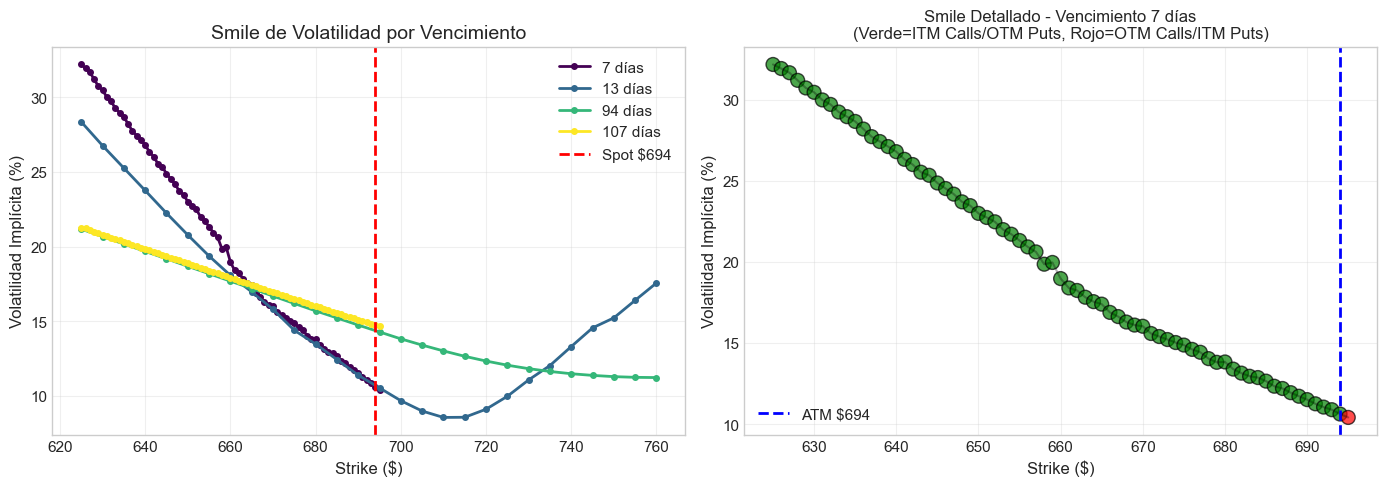


OBSERVACIONES DEL SMILE:
------------------------------------------------------------
   • La IV suele ser mayor en strikes bajos (puts OTM)
   • Esto refleja el 'skew' o asimetría del mercado
   • El mercado paga más por protección contra caídas
   • La forma del smile cambia según el vencimiento


In [26]:
# ============================================================
# VISUALIZACIÓN DEL SMILE DE VOLATILIDAD (2D)
# ============================================================

# Seleccionar algunos vencimientos específicos para mostrar smiles individuales
vencimientos_unicos = sorted(df_superficie['T'].unique())

# Tomar hasta 4 vencimientos representativos
if len(vencimientos_unicos) >= 4:
    venc_seleccionados = [
        vencimientos_unicos[0],  # Más cercano
        vencimientos_unicos[len(vencimientos_unicos)//3],
        vencimientos_unicos[2*len(vencimientos_unicos)//3],
        vencimientos_unicos[-1]  # Más lejano
    ]
else:
    venc_seleccionados = vencimientos_unicos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Smiles individuales por vencimiento
ax1 = axes[0]
colores = plt.cm.viridis(np.linspace(0, 1, len(venc_seleccionados)))

for T_val, color in zip(venc_seleccionados, colores):
    df_venc = df_superficie[df_superficie['T'] == T_val].sort_values('strike')
    dias = int(T_val * 365)
    ax1.plot(df_venc['strike'], df_venc['iv'], 'o-', 
             color=color, label=f'{dias} días', linewidth=2, markersize=4)

ax1.axvline(x=spot, color='red', linestyle='--', linewidth=2, label=f'Spot ${spot:.0f}')
ax1.set_xlabel('Strike ($)', fontsize=12)
ax1.set_ylabel('Volatilidad Implícita (%)', fontsize=12)
ax1.set_title('Smile de Volatilidad por Vencimiento', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Smile para el vencimiento más cercano (detalle)
ax2 = axes[1]
T_cercano = vencimientos_unicos[0]
df_cercano = df_superficie[df_superficie['T'] == T_cercano].sort_values('strike')
dias_cercano = int(T_cercano * 365)

# Colorear por moneyness
colores_moneyness = ['green' if s < spot else 'red' if s > spot else 'blue' 
                      for s in df_cercano['strike']]

ax2.scatter(df_cercano['strike'], df_cercano['iv'], 
            c=colores_moneyness, s=100, alpha=0.7, edgecolors='black')
ax2.plot(df_cercano['strike'], df_cercano['iv'], 'k-', alpha=0.3)

ax2.axvline(x=spot, color='blue', linestyle='--', linewidth=2, label=f'ATM ${spot:.0f}')
ax2.set_xlabel('Strike ($)', fontsize=12)
ax2.set_ylabel('Volatilidad Implícita (%)', fontsize=12)
ax2.set_title(f'Smile Detallado - Vencimiento {dias_cercano} días\n(Verde=ITM Calls/OTM Puts, Rojo=OTM Calls/ITM Puts)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVACIONES DEL SMILE:")
print("-" * 60)
print("   • La IV suele ser mayor en strikes bajos (puts OTM)")
print("   • Esto refleja el 'skew' o asimetría del mercado")
print("   • El mercado paga más por protección contra caídas")
print("   • La forma del smile cambia según el vencimiento")

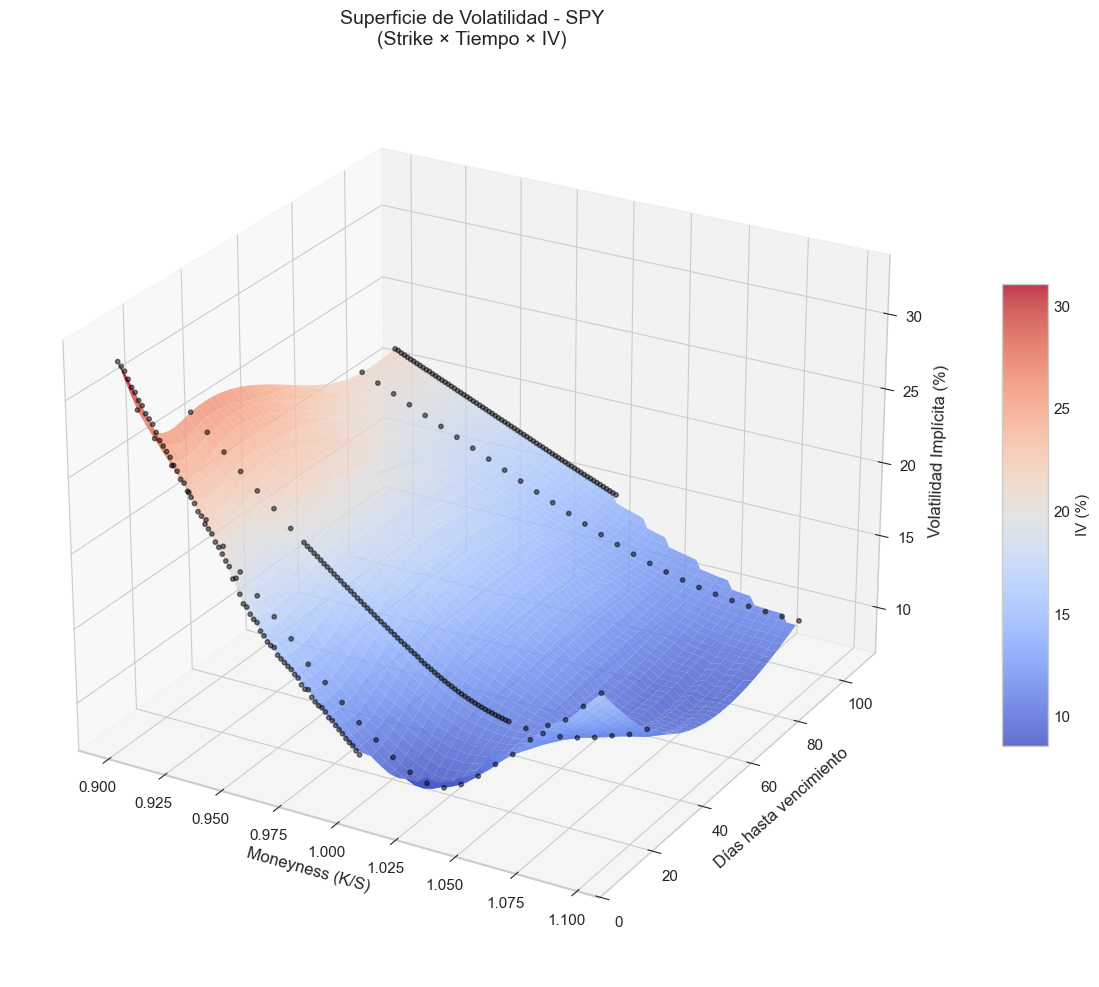


INTERPRETACIÓN:
------------------------------------------------------------
• Las 'alas' elevadas muestran el skew (puts OTM más caros)
• La estructura temporal puede mostrar contango o backwardation
• Discontinuidades indicarían oportunidades de arbitraje


In [27]:
# ============================================================
# VISUALIZACIÓN 3D DE LA SUPERFICIE
# ============================================================

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Crear grid para interpolación
moneyness_grid = np.linspace(df_superficie['moneyness'].min(), df_superficie['moneyness'].max(), 50)
T_grid = np.linspace(df_superficie['T'].min(), df_superficie['T'].max(), 50)
X, Y = np.meshgrid(moneyness_grid, T_grid)

# Interpolación
Z = griddata(
    (df_superficie['moneyness'], df_superficie['T']),
    df_superficie['iv'],
    (X, Y),
    method='cubic'
)

# Superficie
surf = ax.plot_surface(X, Y * 365, Z, cmap=cm.coolwarm, alpha=0.8, linewidth=0, antialiased=True)

# Puntos originales
ax.scatter(df_superficie['moneyness'], df_superficie['T'] * 365, df_superficie['iv'],
           c='black', s=10, alpha=0.5)

ax.set_xlabel('Moneyness (K/S)', fontsize=12)
ax.set_ylabel('Días hasta vencimiento', fontsize=12)
ax.set_zlabel('Volatilidad Implícita (%)', fontsize=12)
ax.set_title('Superficie de Volatilidad - SPY\n(Strike × Tiempo × IV)', fontsize=14)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='IV (%)')

# Vista desde ángulo óptimo
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

print("\nINTERPRETACIÓN:")
print("-" * 60)
print("• Las 'alas' elevadas muestran el skew (puts OTM más caros)")
print("• La estructura temporal puede mostrar contango o backwardation")
print("• Discontinuidades indicarían oportunidades de arbitraje")

## 1.5 Calcular Precio Teórico y Griegas (Δ, Γ, Θ, ν, ρ)

Las griegas miden la sensibilidad del precio de la opción a diferentes factores:

| Griega | Símbolo | Mide sensibilidad a... |
|--------|---------|------------------------|
| Delta | Δ | Precio del subyacente |
| Gamma | Γ | Cambio en delta (2ª derivada) |
| Theta | Θ | Paso del tiempo |
| Vega | ν | Volatilidad implícita |
| Rho | ρ | Tasa de interés |

In [28]:
# ============================================================
# EJEMPLO: PRECIO TEÓRICO Y GRIEGAS
# ============================================================

# Parámetros de ejemplo
S_ejemplo = spot
K_ejemplo = round(spot)  # ATM
T_ejemplo = 30 / 365  # 30 días
sigma_ejemplo = 0.18  # 18% volatilidad

print("CÁLCULO DE PRECIO TEÓRICO Y GRIEGAS")
print("=" * 60)
print(f"\nParámetros:")
print(f"   Spot (S): ${S_ejemplo:.2f}")
print(f"   Strike (K): ${K_ejemplo}")
print(f"   Tiempo (T): 30 días")
print(f"   Volatilidad (σ): {sigma_ejemplo*100:.0f}%")
print(f"   Tasa libre riesgo (r): {r*100:.1f}%")
print(f"   Dividend yield (q): {q*100:.1f}%")

# Calcular precios
precio_call = black_scholes(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'C')
precio_put = black_scholes(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'P')

# Calcular griegas
griegas_call = calcular_griegas(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'C')
griegas_put = calcular_griegas(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'P')

print(f"\nPrecios Teóricos (Black-Scholes):")
print(f"   Call ATM: ${precio_call:.2f} por acción (${precio_call*100:.2f} por contrato)")
print(f"   Put ATM:  ${precio_put:.2f} por acción (${precio_put*100:.2f} por contrato)")

print(f"\nGriegas de la CALL:")
print(f"   Delta (Δ): {griegas_call['delta']:.4f}  → Si SPY sube $1, call sube ${griegas_call['delta']:.2f}")
print(f"   Gamma (Γ): {griegas_call['gamma']:.4f}  → Cambio de delta por $1 de movimiento")
print(f"   Theta (Θ): ${griegas_call['theta']:.4f}/día  → Pérdida diaria por tiempo")
print(f"   Vega (ν):  ${griegas_call['vega']:.4f}  → Cambio por 1% de IV")
print(f"   Rho (ρ):   ${griegas_call['rho']:.4f}  → Cambio por 1% de tasa")

print(f"\nGriegas de la PUT:")
print(f"   Delta (Δ): {griegas_put['delta']:.4f}  → Si SPY sube $1, put baja ${abs(griegas_put['delta']):.2f}")
print(f"   Gamma (Γ): {griegas_put['gamma']:.4f}  → Igual que la call (siempre positivo)")
print(f"   Theta (Θ): ${griegas_put['theta']:.4f}/día  → Pérdida diaria por tiempo")
print(f"   Vega (ν):  ${griegas_put['vega']:.4f}  → Igual que la call")
print(f"   Rho (ρ):   ${griegas_put['rho']:.4f}  → Negativo (puts bajan con tasas altas)")

CÁLCULO DE PRECIO TEÓRICO Y GRIEGAS

Parámetros:
   Spot (S): $694.02
   Strike (K): $694
   Tiempo (T): 30 días
   Volatilidad (σ): 18%
   Tasa libre riesgo (r): 4.5%
   Dividend yield (q): 1.3%

Precios Teóricos (Black-Scholes):
   Call ATM: $15.19 por acción ($1519.15 por contrato)
   Put ATM:  $13.35 por acción ($1335.06 por contrato)

Griegas de la CALL:
   Delta (Δ): 0.5303  → Si SPY sube $1, call sube $0.53
   Gamma (Γ): 0.0111  → Cambio de delta por $1 de movimiento
   Theta (Θ): $-0.2676/día  → Pérdida diaria por tiempo
   Vega (ν):  $0.7906  → Cambio por 1% de IV
   Rho (ρ):   $0.2900  → Cambio por 1% de tasa

Griegas de la PUT:
   Delta (Δ): -0.4687  → Si SPY sube $1, put baja $0.47
   Gamma (Γ): 0.0111  → Igual que la call (siempre positivo)
   Theta (Θ): $-0.2070/día  → Pérdida diaria por tiempo
   Vega (ν):  $0.7906  → Igual que la call
   Rho (ρ):   $-0.2783  → Negativo (puts bajan con tasas altas)


## 1.6 Evolución Temporal Histórica (Griegas y Payoff)

Las griegas no son constantes: cambian dramáticamente conforme se acerca el vencimiento:

- **Gamma**: Explota cerca del vencimiento para opciones ATM
- **Theta**: Acelera su decaimiento en las últimas semanas
- **Vega**: Disminuye (menos tiempo = menos impacto de volatilidad)

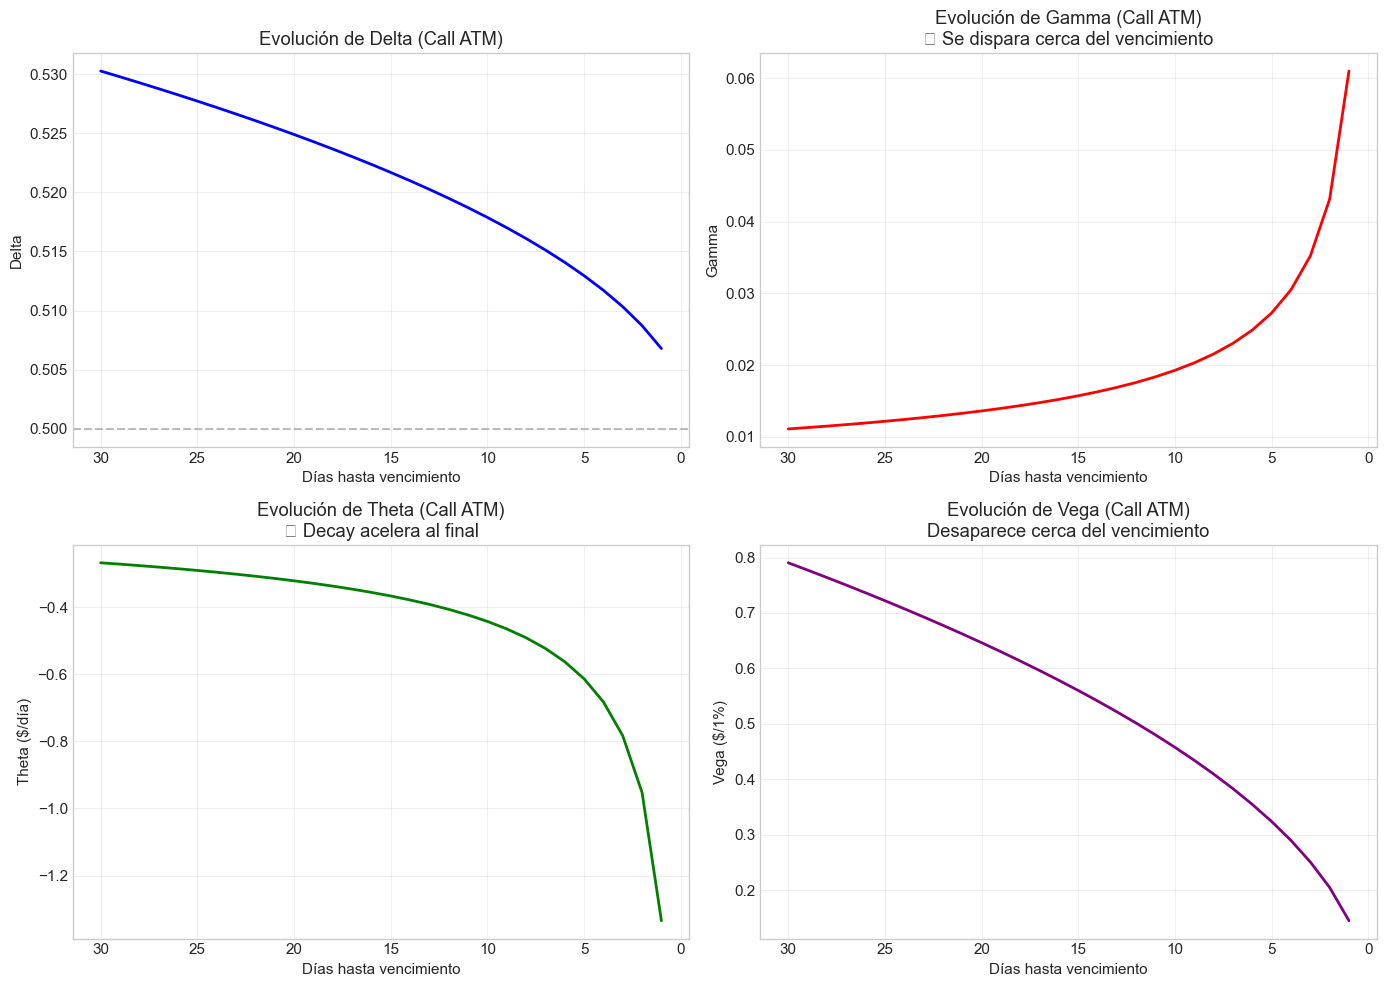


CONCLUSIONES CLAVE:
------------------------------------------------------------
• GAMMA: Peligroso cerca del vencimiento para opciones ATM
• THETA: La última semana es cuando más valor se pierde
• VEGA: No tiene sentido comprar volatilidad a días del vencimiento


In [29]:
# ============================================================
# EVOLUCIÓN TEMPORAL DE GRIEGAS
# ============================================================

# Parámetros
K = round(spot)  # ATM
sigma = 0.18
T_inicial = 30 / 365  # 30 días

# Simular evolución día a día
dias = np.arange(30, 0, -1)
tiempos = dias / 365

evolucion = []
for t in tiempos:
    g = calcular_griegas(spot, K, t, r, sigma, q, 'C')
    g['dias_restantes'] = t * 365
    g['T'] = t
    evolucion.append(g)

df_evolucion = pd.DataFrame(evolucion)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Delta
ax1 = axes[0, 0]
ax1.plot(df_evolucion['dias_restantes'], df_evolucion['delta'], 'b-', linewidth=2)
ax1.set_xlabel('Días hasta vencimiento')
ax1.set_ylabel('Delta')
ax1.set_title('Evolución de Delta (Call ATM)')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

# Gamma
ax2 = axes[0, 1]
ax2.plot(df_evolucion['dias_restantes'], df_evolucion['gamma'], 'r-', linewidth=2)
ax2.set_xlabel('Días hasta vencimiento')
ax2.set_ylabel('Gamma')
ax2.set_title('Evolución de Gamma (Call ATM)\nSe dispara cerca del vencimiento')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)

# Theta
ax3 = axes[1, 0]
ax3.plot(df_evolucion['dias_restantes'], df_evolucion['theta'], 'g-', linewidth=2)
ax3.set_xlabel('Días hasta vencimiento')
ax3.set_ylabel('Theta ($/día)')
ax3.set_title('Evolución de Theta (Call ATM)\nDecay acelera al final')
ax3.invert_xaxis()
ax3.grid(True, alpha=0.3)

# Vega
ax4 = axes[1, 1]
ax4.plot(df_evolucion['dias_restantes'], df_evolucion['vega'], 'purple', linewidth=2)
ax4.set_xlabel('Días hasta vencimiento')
ax4.set_ylabel('Vega ($/1%)')
ax4.set_title('Evolución de Vega (Call ATM)\nDesaparece cerca del vencimiento')
ax4.invert_xaxis()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIONES CLAVE:")
print("-" * 60)
print("• GAMMA: Peligroso cerca del vencimiento para opciones ATM")
print("• THETA: La última semana es cuando más valor se pierde")
print("• VEGA: No tiene sentido comprar volatilidad a días del vencimiento")

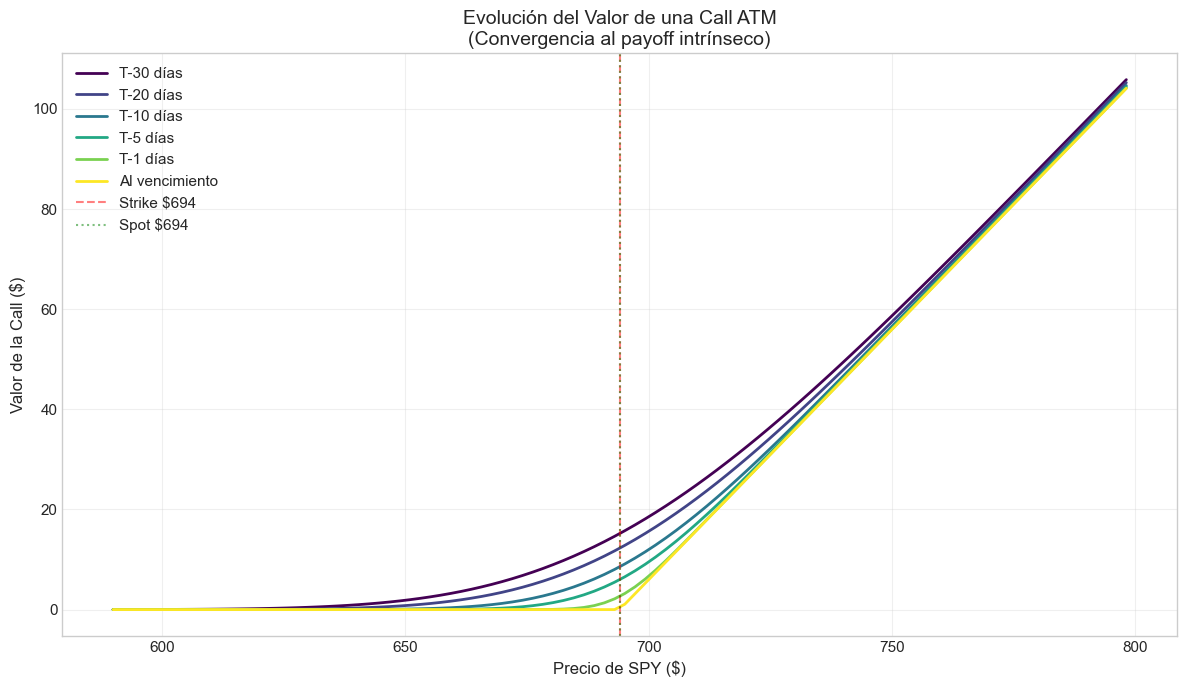

In [30]:
# ============================================================
# EVOLUCIÓN DEL PAYOFF EN EL TIEMPO
# ============================================================

precios = np.linspace(spot * 0.85, spot * 1.15, 100)
tiempos_plot = [30, 20, 10, 5, 1, 0]  # días

fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(tiempos_plot)))

for i, dias_rest in enumerate(tiempos_plot):
    T_calc = dias_rest / 365
    if T_calc > 0:
        valores = [black_scholes(S, K, T_calc, r, sigma, q, 'C') for S in precios]
        label = f'T-{dias_rest} días'
    else:
        valores = [max(S - K, 0) for S in precios]
        label = 'Al vencimiento'
    
    ax.plot(precios, valores, color=colors[i], linewidth=2, label=label)

ax.axvline(x=K, color='red', linestyle='--', alpha=0.5, label=f'Strike ${K}')
ax.axvline(x=spot, color='green', linestyle=':', alpha=0.5, label=f'Spot ${spot:.0f}')

ax.set_xlabel('Precio de SPY ($)', fontsize=12)
ax.set_ylabel('Valor de la Call ($)', fontsize=12)
ax.set_title('Evolución del Valor de una Call ATM\n(Convergencia al payoff intrínseco)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.7 Función de Cobertura: Posición Cubierta vs Expuesta (Delta-Hedging)

### ¿Qué es el Delta-Hedging?

Cuando tenemos opciones, estamos expuestos al movimiento del subyacente. El delta-hedging neutraliza esta exposición comprando/vendiendo acciones:

- **Posición expuesta**: Solo tenemos la opción, el P&L depende de hacia dónde se mueva el mercado
- **Posición cubierta**: Opción + acciones en proporción -delta, P&L independiente de la dirección

### Gamma Scalping

Al rebalancear continuamente, "capturamos" el gamma: compramos barato cuando baja y vendemos caro cuando sube.

In [31]:
# ============================================================
# SIMULACIÓN DE DELTA-HEDGING CON ACCIONES (GAMMA SCALPING)
# ============================================================

def simular_delta_hedge(spot_inicial, K, T_dias, sigma, r, q, num_rebalanceos=10, seed=42):
    """
    Simula un straddle con y sin delta-hedging usando acciones.
    
    Parámetros:
    -----------
    spot_inicial : precio inicial del subyacente
    K : strike del straddle (ATM)
    T_dias : días hasta vencimiento
    sigma : volatilidad para simular el precio
    r, q : tasa libre de riesgo y dividend yield
    num_rebalanceos : cada cuántos pasos rebalanceamos
    """
    np.random.seed(seed)
    
    T = T_dias / 365
    dt = T / T_dias  # paso diario
    
    # Simular path del precio (GBM)
    precios = [spot_inicial]
    for _ in range(T_dias):
        dW = np.random.normal(0, np.sqrt(dt))
        S_nuevo = precios[-1] * np.exp((r - q - 0.5*sigma**2)*dt + sigma*dW)
        precios.append(S_nuevo)
    precios = np.array(precios)
    
    # Costo inicial del straddle
    call_inicial = black_scholes(spot_inicial, K, T, r, sigma, q, 'C')
    put_inicial = black_scholes(spot_inicial, K, T, r, sigma, q, 'P')
    costo_straddle = (call_inicial + put_inicial) * 100
    
    # ===== SIMULACIÓN SIN HEDGE =====
    spot_final = precios[-1]
    payoff_sin_hedge = abs(spot_final - K) * 100
    pnl_sin_hedge = payoff_sin_hedge - costo_straddle
    
    # ===== SIMULACIÓN CON DELTA-HEDGE =====
    posicion_acciones = 0  # acciones en cartera (+ = long, - = short)
    cash_hedge = 0  # P&L del hedging
    historial_hedge = []
    
    for dia in range(T_dias):
        S = precios[dia]
        T_restante = (T_dias - dia) / 365
        
        if T_restante <= 0:
            break
        
        # Calcular delta actual del straddle
        delta_call = calcular_griegas(S, K, T_restante, r, sigma, q, 'C')['delta']
        delta_put = calcular_griegas(S, K, T_restante, r, sigma, q, 'P')['delta']
        delta_straddle = (delta_call + delta_put) * 100  # por 100 acciones
        
        # Rebalancear cada N días
        if dia % num_rebalanceos == 0:
            # Acciones necesarias para neutralizar = -delta_straddle
            acciones_objetivo = -delta_straddle
            acciones_a_operar = acciones_objetivo - posicion_acciones
            
            # Ejecutar trade de acciones
            cash_hedge -= acciones_a_operar * S  # compramos (+) o vendemos (-)
            posicion_acciones = acciones_objetivo
            
            historial_hedge.append({
                'dia': dia,
                'spot': S,
                'delta_straddle': delta_straddle,
                'acciones_operadas': acciones_a_operar,
                'posicion_total': posicion_acciones
            })
    
    # Cerrar posición de acciones al vencimiento
    cash_hedge += posicion_acciones * precios[-1]
    
    # P&L total con hedge
    pnl_con_hedge = payoff_sin_hedge - costo_straddle + cash_hedge
    
    return {
        'precios': precios,
        'costo_straddle': costo_straddle,
        'payoff': payoff_sin_hedge,
        'pnl_sin_hedge': pnl_sin_hedge,
        'pnl_con_hedge': pnl_con_hedge,
        'ganancia_hedge': cash_hedge,
        'historial': pd.DataFrame(historial_hedge)
    }


# ============================================================
# EJECUTAR SIMULACIÓN
# ============================================================

print("SIMULACIÓN: STRADDLE CON VS SIN DELTA-HEDGING")
print("=" * 60)

# Parámetros
spot_sim = spot
K_sim = round(spot)
T_sim = 30  # 30 días
sigma_sim = 0.20  # 20% vol

resultado = simular_delta_hedge(spot_sim, K_sim, T_sim, sigma_sim, r, q, num_rebalanceos=5)

print(f"\nParámetros:")
print(f"   Spot inicial: ${spot_sim:.2f}")
print(f"   Strike: ${K_sim}")
print(f"   Días: {T_sim}")
print(f"   Volatilidad: {sigma_sim*100:.0f}%")
print(f"   Rebalanceo cada: 5 días")

print(f"\nResultados:")
print(f"   Costo del straddle: ${resultado['costo_straddle']:.2f}")
print(f"   Payoff al vencimiento: ${resultado['payoff']:.2f}")
print(f"   " + "-" * 40)
print(f"   P&L SIN hedge: ${resultado['pnl_sin_hedge']:.2f}")
print(f"   P&L CON hedge: ${resultado['pnl_con_hedge']:.2f}")
print(f"   Ganancia por hedging: ${resultado['ganancia_hedge']:.2f}")

print(f"\nHistorial de rebalanceos:")
print(resultado['historial'].to_string(index=False))

SIMULACIÓN: STRADDLE CON VS SIN DELTA-HEDGING

Parámetros:
   Spot inicial: $694.02
   Strike: $694
   Días: 30
   Volatilidad: 20%
   Rebalanceo cada: 5 días

Resultados:
   Costo del straddle: $3170.46
   Payoff al vencimiento: $3915.49
   ----------------------------------------
   P&L SIN hedge: $745.03
   P&L CON hedge: $1189.18
   Ganancia por hedging: $444.15

Historial de rebalanceos:
 dia       spot  delta_straddle  acciones_operadas  posicion_total
   0 694.020000        5.975505          -5.975505       -5.975505
   5 711.012831       40.404056         -34.428551      -40.404056
  10 727.587835       71.504871         -31.100815      -71.504871
  15 695.491597        8.410391          63.094479       -8.410391
  20 670.010649      -69.184419          77.594811       69.184419
  25 665.494705      -92.164847          22.980428       92.164847


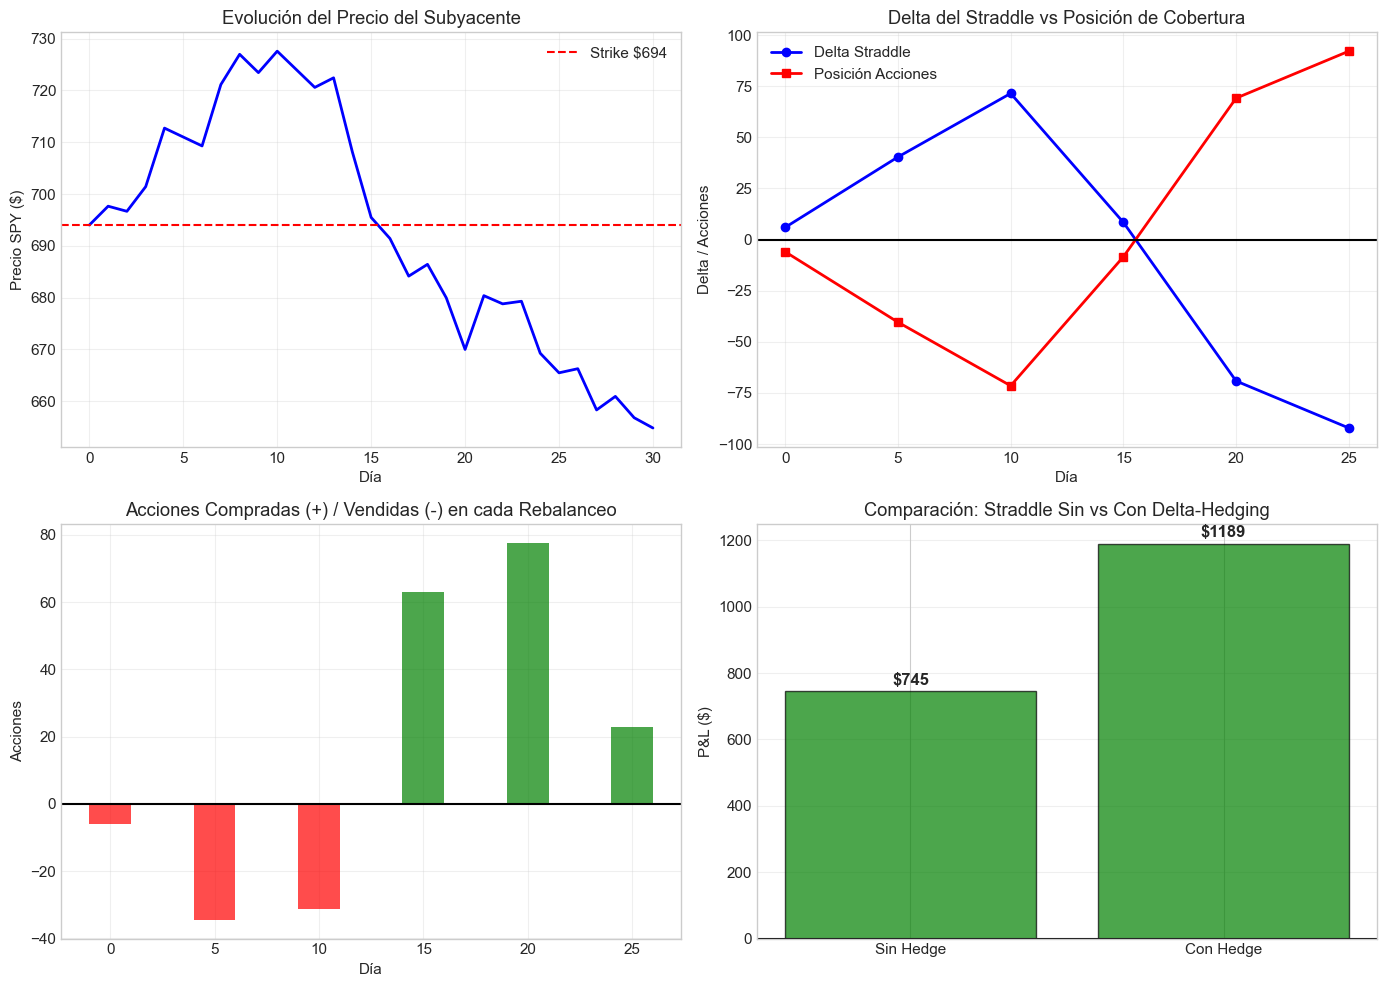


CONCLUSIÓN:
------------------------------------------------------------
   El delta-hedging (gamma scalping) genera P&L adicional
   al comprar barato y vender caro durante los rebalanceos.
   Si vol realizada > vol implícita pagada: GANAMOS.
   Si vol realizada < vol implícita pagada: PERDEMOS.


In [32]:
# ============================================================
# VISUALIZACIÓN DEL DELTA-HEDGING
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precio del subyacente
ax1 = axes[0, 0]
ax1.plot(resultado['precios'], 'b-', linewidth=2)
ax1.axhline(y=K_sim, color='red', linestyle='--', label=f'Strike ${K_sim}')
ax1.set_xlabel('Día')
ax1.set_ylabel('Precio SPY ($)')
ax1.set_title('Evolución del Precio del Subyacente')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta del straddle y posición en acciones
ax2 = axes[0, 1]
df_h = resultado['historial']
ax2.plot(df_h['dia'], df_h['delta_straddle'], 'b-o', label='Delta Straddle', linewidth=2)
ax2.plot(df_h['dia'], df_h['posicion_total'], 'r-s', label='Posición Acciones', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Día')
ax2.set_ylabel('Delta / Acciones')
ax2.set_title('Delta del Straddle vs Posición de Cobertura')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Acciones operadas en cada rebalanceo
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in df_h['acciones_operadas']]
ax3.bar(df_h['dia'], df_h['acciones_operadas'], color=colors, alpha=0.7, width=2)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_xlabel('Día')
ax3.set_ylabel('Acciones')
ax3.set_title('Acciones Compradas (+) / Vendidas (-) en cada Rebalanceo')
ax3.grid(True, alpha=0.3)

# 4. Comparación P&L
ax4 = axes[1, 1]
categorias = ['Sin Hedge', 'Con Hedge']
valores = [resultado['pnl_sin_hedge'], resultado['pnl_con_hedge']]
colores = ['red' if v < 0 else 'green' for v in valores]
bars = ax4.bar(categorias, valores, color=colores, alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-')
ax4.set_ylabel('P&L ($)')
ax4.set_title('Comparación: Straddle Sin vs Con Delta-Hedging')
for bar, val in zip(bars, valores):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 20, f'${val:.0f}', 
             ha='center', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCONCLUSIÓN:")
print("-" * 60)
print("   El delta-hedging (gamma scalping) genera P&L adicional")
print("   al comprar barato y vender caro durante los rebalanceos.")
print("   Si vol realizada > vol implícita pagada: GANAMOS.")
print("   Si vol realizada < vol implícita pagada: PERDEMOS.")

Ejecutando 2000 simulaciones...

Estadísticas sobre 2000 simulaciones:
   Métrica                      Sin Hedge    Con Hedge
   --------------------------------------------------
   P&L Promedio              $    138.04 $     27.59
   P&L Mediano               $   -323.79 $    -11.90
   Desv. Estándar            $   2520.30 $   1099.03
   % Rentables                     45.2%       49.5%


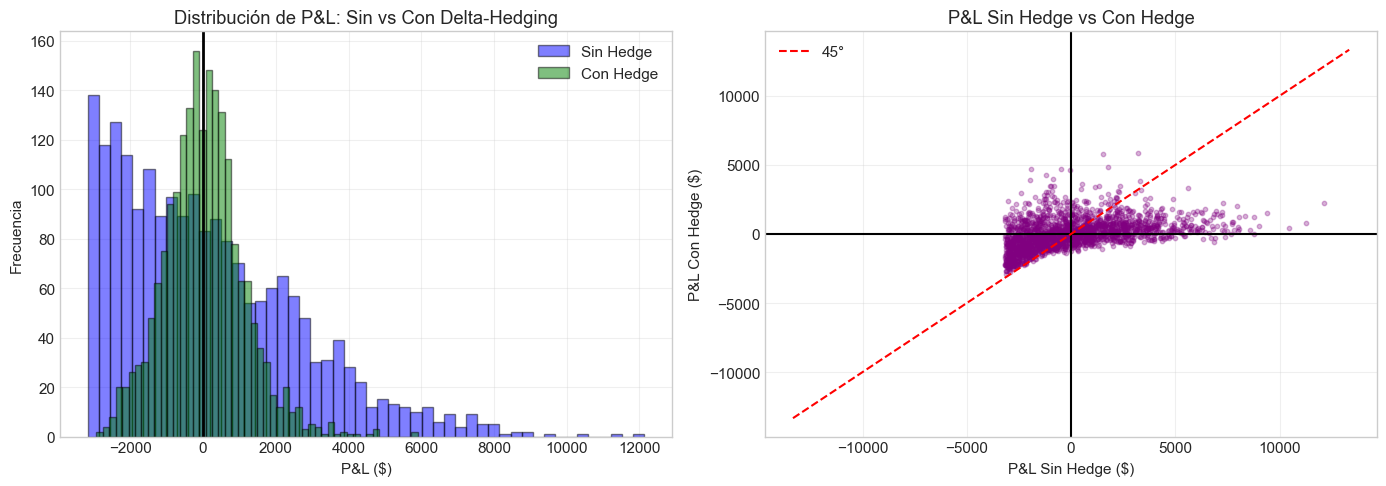


INTERPRETACIÓN:
------------------------------------------------------------
   • El hedge REDUCE la varianza del P&L (menos riesgo)
   • En promedio, el resultado depende de IV vs Vol Realizada
   • El scatter muestra que hedge y sin-hedge están correlacionados
   • pero el hedge suaviza los extremos


In [33]:
# ============================================================
# MÚLTIPLES SIMULACIONES: DISTRIBUCIÓN DE RESULTADOS
# ============================================================

print("Ejecutando 2000 simulaciones...")

resultados_mc = []
for i in range(2000):
    res = simular_delta_hedge(spot_sim, K_sim, T_sim, sigma_sim, r, q, 
                               num_rebalanceos=5, seed=i)
    resultados_mc.append({
        'pnl_sin_hedge': res['pnl_sin_hedge'],
        'pnl_con_hedge': res['pnl_con_hedge'],
        'ganancia_hedge': res['ganancia_hedge']
    })

df_mc = pd.DataFrame(resultados_mc)

print(f"\nEstadísticas sobre 2000 simulaciones:")
print(f"   " + "=" * 50)
print(f"   {'Métrica':<25} {'Sin Hedge':>12} {'Con Hedge':>12}")
print(f"   " + "-" * 50)
print(f"   {'P&L Promedio':<25} ${df_mc['pnl_sin_hedge'].mean():>10.2f} ${df_mc['pnl_con_hedge'].mean():>10.2f}")
print(f"   {'P&L Mediano':<25} ${df_mc['pnl_sin_hedge'].median():>10.2f} ${df_mc['pnl_con_hedge'].median():>10.2f}")
print(f"   {'Desv. Estándar':<25} ${df_mc['pnl_sin_hedge'].std():>10.2f} ${df_mc['pnl_con_hedge'].std():>10.2f}")
print(f"   {'% Rentables':<25} {(df_mc['pnl_sin_hedge']>0).mean()*100:>10.1f}% {(df_mc['pnl_con_hedge']>0).mean()*100:>10.1f}%")
print(f"   " + "=" * 50)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(df_mc['pnl_sin_hedge'], bins=50, alpha=0.5, label='Sin Hedge', color='blue', edgecolor='black')
ax1.hist(df_mc['pnl_con_hedge'], bins=50, alpha=0.5, label='Con Hedge', color='green', edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('P&L ($)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de P&L: Sin vs Con Delta-Hedging')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.scatter(df_mc['pnl_sin_hedge'], df_mc['pnl_con_hedge'], alpha=0.3, s=10, c='purple')
ax2.axhline(y=0, color='black', linestyle='-')
ax2.axvline(x=0, color='black', linestyle='-')
lim = max(abs(df_mc['pnl_sin_hedge']).max(), abs(df_mc['pnl_con_hedge']).max()) * 1.1
ax2.plot([-lim, lim], [-lim, lim], 'r--', label='45°')
ax2.set_xlabel('P&L Sin Hedge ($)')
ax2.set_ylabel('P&L Con Hedge ($)')
ax2.set_title('P&L Sin Hedge vs Con Hedge')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nINTERPRETACIÓN:")
print("-" * 60)
print("   • El hedge REDUCE la varianza del P&L (menos riesgo)")
print("   • En promedio, el resultado depende de IV vs Vol Realizada")
print("   • El scatter muestra que hedge y sin-hedge están correlacionados")
print("   • pero el hedge suaviza los extremos")

## 1.8 Simular Envío de Órdenes y Cobertura

Implementamos funciones para enviar órdenes a Interactive Brokers:

- **Orden simple**: Comprar/vender una opción individual
- **Orden combo**: Ejecutar múltiples patas simultáneamente (straddle, spread)
- **Sistema de confirmación**: Verificación de tipo de cuenta y confirmación explícita

In [34]:
# ============================================================
# ENVÍO DE ÓRDENES A IBKR (Corregido y Seguro)
# ============================================================

from ib_insync import IB, Option, MarketOrder, Contract, ComboLeg # Asegurar imports

# Definimos la variable que faltaba
IBKR_DISPONIBLE = True 

def crear_orden_opcion_simple(ib, simbolo, strike, vencimiento, tipo_opcion, accion, cantidad):
    """
    Crea y envía una orden simple de opción.
    """
    contrato = Option(
        symbol=simbolo,
        lastTradeDateOrContractMonth=vencimiento,
        strike=strike,
        right=tipo_opcion,
        exchange='SMART',
        currency='USD'
    )
    
    # Calificar el contrato
    ib.qualifyContracts(contrato)
    
    # Crear orden de mercado
    orden = MarketOrder(accion, cantidad)
    
    # Enviar
    trade = ib.placeOrder(contrato, orden)
    
    return trade

def crear_orden_straddle_combo(ib, simbolo, strike, vencimiento, accion, cantidad):
    """
    Crea un combo de straddle (call + put mismo strike).
    """
    # Crear contratos individuales
    call = Option(simbolo, vencimiento, strike, 'C', 'SMART')
    put = Option(simbolo, vencimiento, strike, 'P', 'SMART')
    
    # Es crucial calificar las patas antes de armar el combo
    ib.qualifyContracts(call, put)
    
    # Crear combo
    combo = Contract()
    combo.symbol = simbolo
    combo.secType = 'BAG'
    combo.currency = 'USD'
    combo.exchange = 'SMART'
    
    leg1 = ComboLeg()
    leg1.conId = call.conId
    leg1.ratio = 1
    leg1.action = accion
    leg1.exchange = 'SMART'
    
    leg2 = ComboLeg()
    leg2.conId = put.conId
    leg2.ratio = 1
    leg2.action = accion
    leg2.exchange = 'SMART'
    
    combo.comboLegs = [leg1, leg2]
    
    orden = MarketOrder(accion, cantidad)
    trade = ib.placeOrder(combo, orden)
    
    return trade


# ============================================================
# GESTIÓN DE LA CONEXIÓN (Inteligente)
# ============================================================

# Verificar si ya existe una conexión activa para no sobrescribirla
if 'ib' in globals() and ib is not None and ib.isConnected():
    print(f"[OK] Ya existe una conexión activa a IBKR (Cuenta: {ib.managedAccounts()})")
    print("  Se utilizará la conexión existente.")

elif IBKR_DISPONIBLE:
    try:
        print("Intentando conectar a IBKR...")
        ib = IB()
        # Nota: clientId=11 para evitar conflicto si la sesión anterior quedó colgada
        ib.connect('127.0.0.1', 7497, clientId=11) 
        print(f"[OK] Conectado a IBKR")
        print(f"  Cuentas: {ib.managedAccounts()}")
    except Exception as e:
        print(f"No se pudo conectar a IBKR: {e}")
        ib = None
else:
    print("Modo IBKR desactivado (IBKR_DISPONIBLE = False)")
    ib = None

# ============================================================
# EJEMPLO DE USO
# ============================================================

print("\nCÓDIGO PARA ENVÍO DE ÓRDENES A IBKR")
print("=" * 60)

if ib is not None and ib.isConnected():
    print("\n[OK] Conectado a IBKR - Puedes ejecutar las funciones de arriba")
    print("\nEjemplo de uso (Copia y modifica esto en una celda nueva):")
    print("""
    # 1. Definir parámetros
    symbol = 'SPY'
    strike = 600  # Ajustar a un strike realista
    expiration = '20250620' # Ajustar fecha (YYYYMMDD)

    # 2. Enviar Orden Simple (CUIDADO: Es una orden real en Paper Trading)
    # trade_simple = crear_orden_opcion_simple(ib, symbol, strike, expiration, 'C', 'BUY', 1)
    
    # 3. Enviar Combo Straddle
    # trade_combo = crear_orden_straddle_combo(ib, symbol, strike, expiration, 'BUY', 1)
    """)
else:
    print("\nIBKR no conectado - Revisa que TWS/Gateway esté abierto en puerto 7497")

[OK] Ya existe una conexión activa a IBKR (Cuenta: ['DUM355962'])
  Se utilizará la conexión existente.

CÓDIGO PARA ENVÍO DE ÓRDENES A IBKR

[OK] Conectado a IBKR - Puedes ejecutar las funciones de arriba

Ejemplo de uso (Copia y modifica esto en una celda nueva):

    # 1. Definir parámetros
    symbol = 'SPY'
    strike = 600  # Ajustar a un strike realista
    expiration = '20250620' # Ajustar fecha (YYYYMMDD)

    # 2. Enviar Orden Simple (CUIDADO: Es una orden real en Paper Trading)
    # trade_simple = crear_orden_opcion_simple(ib, symbol, strike, expiration, 'C', 'BUY', 1)

    # 3. Enviar Combo Straddle
    # trade_combo = crear_orden_straddle_combo(ib, symbol, strike, expiration, 'BUY', 1)
    


In [35]:
# ============================================================
# ENVÍO REAL DE ÓRDENES A IBKR (CON CONFIRMACIÓN)
# ============================================================

def detectar_tipo_cuenta(ib):
    """
    Detecta si estamos conectados a una cuenta Paper o Real.
    Las cuentas Paper de IBKR suelen empezar con 'D' (Demo).
    """
    cuentas = ib.managedAccounts()
    if not cuentas:
        return "DESCONOCIDA", None
    
    cuenta = cuentas[0]
    # Cuentas paper suelen empezar con 'D' (DU, DF, etc.)
    if cuenta.startswith('D'):
        return "PAPER (SIMULACIÓN)", cuenta
    else:
        return "REAL (DINERO REAL)", cuenta


def enviar_orden_con_confirmacion(ib, tipo_orden, **kwargs):
    """
    Envía una orden a IBKR pidiendo confirmación explícita al usuario.
    
    Parámetros:
    -----------
    ib : objeto IB conectado
    tipo_orden : str ('simple' o 'straddle')
    **kwargs : parámetros de la orden (simbolo, strike, vencimiento, etc.)
    """
    # Verificar conexión
    if ib is None or not ib.isConnected():
        print("ERROR: No hay conexión activa con IBKR.")
        print("   Ejecuta primero la celda de conexión.")
        return None
    
    # Detectar tipo de cuenta
    tipo_cuenta, num_cuenta = detectar_tipo_cuenta(ib)
    
    # Mostrar información de la orden
    print("=" * 60)
    print("RESUMEN DE LA ORDEN")
    print("=" * 60)
    print(f"\nTIPO DE CUENTA: {tipo_cuenta}")
    print(f"   Número de cuenta: {num_cuenta}")
    
    if "REAL" in tipo_cuenta:
        print("\n" + "" * 20)
        print("   ¡¡¡ATENCIÓN: ESTÁS EN UNA CUENTA CON DINERO REAL!!!")
        print("" * 20)
    
    print(f"\nDetalles de la orden:")
    print(f"   Tipo: {tipo_orden.upper()}")
    print(f"   Símbolo: {kwargs.get('simbolo', 'N/A')}")
    print(f"   Strike: ${kwargs.get('strike', 'N/A')}")
    print(f"   Vencimiento: {kwargs.get('vencimiento', 'N/A')}")
    print(f"   Acción: {kwargs.get('accion', 'N/A')}")
    print(f"   Cantidad: {kwargs.get('cantidad', 'N/A')}")
    
    if tipo_orden == 'simple':
        print(f"   Tipo opción: {'CALL' if kwargs.get('tipo_opcion') == 'C' else 'PUT'}")
    elif tipo_orden == 'straddle':
        print(f"   Tipo opción: STRADDLE (CALL + PUT)")
    
    # Pedir confirmación
    print("\n" + "-" * 60)
    confirmacion = input("¿Confirmas el envío de esta orden? (escribe 'SI' para confirmar): ")
    
    if confirmacion.strip().upper() != 'SI':
        print("\nOrden CANCELADA por el usuario.")
        return None
    
    # Ejecutar la orden
    print("\n⏳ Enviando orden...")
    
    try:
        if tipo_orden == 'simple':
            trade = crear_orden_opcion_simple(
                ib,
                kwargs['simbolo'],
                kwargs['strike'],
                kwargs['vencimiento'],
                kwargs['tipo_opcion'],
                kwargs['accion'],
                kwargs['cantidad']
            )
        elif tipo_orden == 'straddle':
            trade = crear_orden_straddle_combo(
                ib,
                kwargs['simbolo'],
                kwargs['strike'],
                kwargs['vencimiento'],
                kwargs['accion'],
                kwargs['cantidad']
            )
        else:
            print(f"Tipo de orden no reconocido: {tipo_orden}")
            return None
        
        # Esperar un momento para que se procese
        ib.sleep(1)
        
        print(f"\nOrden enviada correctamente.")
        print(f"   Estado: {trade.orderStatus.status}")
        print(f"   Order ID: {trade.order.orderId}")
        
        return trade
        
    except Exception as e:
        print(f"\nERROR al enviar la orden: {e}")
        return None


# ============================================================
# EJEMPLO DE USO
# ============================================================

print("FUNCIONES DE ENVÍO CON CONFIRMACIÓN CARGADAS")
print("=" * 60)
print("\nEjemplos de uso:")
print("""
# Opción simple (call o put):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='simple',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    tipo_opcion='C',      # 'C' para Call, 'P' para Put
    accion='BUY',         # 'BUY' o 'SELL'
    cantidad=1
)

# Straddle (call + put mismo strike):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='straddle',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    accion='BUY',
    cantidad=1
)
""")

# Mostrar estado de conexión actual
if ib is not None and ib.isConnected():
    tipo_cuenta, num_cuenta = detectar_tipo_cuenta(ib)
    print(f"\nConexión activa: {tipo_cuenta} ({num_cuenta})")
else:
    print("\nNo hay conexión activa con IBKR.")

FUNCIONES DE ENVÍO CON CONFIRMACIÓN CARGADAS

Ejemplos de uso:

# Opción simple (call o put):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='simple',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    tipo_opcion='C',      # 'C' para Call, 'P' para Put
    accion='BUY',         # 'BUY' o 'SELL'
    cantidad=1
)

# Straddle (call + put mismo strike):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='straddle',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    accion='BUY',
    cantidad=1
)


Conexión activa: PAPER (SIMULACIÓN) (DUM355962)


# ═══════════════════════════════════════════════════════════════
# PARTE 2: ESTRATEGIAS
# ═══════════════════════════════════════════════════════════════

## 2.1 Estrategia Long Straddle Periódico sobre SPY

### ¿Qué es un Long Straddle?

Comprar simultáneamente una call y una put ATM con el mismo vencimiento. Apostamos a que el mercado se moverá mucho, sin importar la dirección.

### Estrategia Periódica

Cada mes compramos un straddle ATM a 30 días y lo mantenemos hasta vencimiento. Analizamos si esta estrategia sistemática es rentable.

In [36]:
# ============================================================
# BACKTEST HISTÓRICO DE STRADDLE
# ============================================================
# NOTA: Para datos históricos de 2 años usamos yfinance ya que
# IBKR tiene limitaciones en datos históricos para cuentas paper.
# Los datos de opciones en tiempo real sí vienen de IBKR.

import yfinance as yf

print("Descargando datos históricos de SPY (vía yfinance para histórico largo)...")

# Obtener 2 años de datos
spy_hist = yf.download('SPY', period='2y', progress=False)

# Aplanar MultiIndex de columnas si existe (versiones recientes de yfinance)
if isinstance(spy_hist.columns, pd.MultiIndex):
    spy_hist.columns = spy_hist.columns.get_level_values(0)

spy_hist['Returns'] = spy_hist['Close'].pct_change()

# Calcular volatilidad realizada rolling 30 días
spy_hist['RealizedVol'] = spy_hist['Returns'].rolling(30).std() * np.sqrt(252) * 100

print(f"[OK] Datos obtenidos: {len(spy_hist)} días")

# Simular straddles mensuales
resultados_backtest = []
IV_ASUMIDA = 18  # Asumimos IV promedio del 18%

for i in range(0, len(spy_hist) - 30, 21):  # Cada ~21 días de trading
    fecha_entrada = spy_hist.index[i]
    fecha_salida = spy_hist.index[min(i + 30, len(spy_hist) - 1)]
    
    # Extraer valores escalares (float) explícitamente
    spot_entrada = float(spy_hist.loc[fecha_entrada, 'Close'])
    spot_salida = float(spy_hist.loc[fecha_salida, 'Close'])
    
    K = spot_entrada
    T = 30 / 365
    sigma_impl = IV_ASUMIDA / 100
    
    # Costo del straddle
    call_precio = black_scholes(spot_entrada, K, T, r, sigma_impl, q, 'C')
    put_precio = black_scholes(spot_entrada, K, T, r, sigma_impl, q, 'P')
    costo_straddle = (call_precio + put_precio) * 100
    
    # Payoff al vencimiento
    payoff = (abs(spot_salida - K)) * 100
    
    # P&L
    pnl = payoff - costo_straddle
    movimiento_pct = abs(spot_salida / spot_entrada - 1) * 100
    
    # Volatilidad realizada en ese período (extraer como escalar)
    vol_realizada = float(spy_hist.loc[fecha_entrada:fecha_salida, 'Returns'].std() * np.sqrt(252) * 100)
    
    resultados_backtest.append({
        'fecha_entrada': fecha_entrada,
        'fecha_salida': fecha_salida,
        'spot_entrada': spot_entrada,
        'spot_salida': spot_salida,
        'costo': costo_straddle,
        'payoff': payoff,
        'pnl': pnl,
        'movimiento_pct': movimiento_pct,
        'vol_impl': IV_ASUMIDA,
        'vol_real': vol_realizada
    })

df_backtest = pd.DataFrame(resultados_backtest)
df_backtest['fecha_entrada'] = pd.to_datetime(df_backtest['fecha_entrada'])

print(f"\n[OK] Straddles simulados: {len(df_backtest)}")

Descargando datos históricos de SPY (vía yfinance para histórico largo)...
[OK] Datos obtenidos: 501 días

[OK] Straddles simulados: 23


## 2.2 Versión Delta-Hedged con el Subyacente

Comparamos el straddle "naked" (sin cobertura) vs el straddle con delta-hedging dinámico usando acciones de SPY.

El backtest histórico a continuación compara ambas versiones.

In [37]:
# ============================================================
# BACKTEST HISTÓRICO: STRADDLE VS DELTA-HEDGED
# ============================================================

def backtest_straddle_con_hedge(spy_data, fecha_entrada, dias_holding=30, rebalanceo_cada=5):
    """
    Simula un straddle con y sin delta-hedging usando datos históricos reales.
    """
    idx_entrada = spy_data.index.get_loc(fecha_entrada)
    idx_salida = min(idx_entrada + dias_holding, len(spy_data) - 1)
    
    spot_entrada = float(spy_data.iloc[idx_entrada]['Close'])
    spot_salida = float(spy_data.iloc[idx_salida]['Close'])
    
    K = spot_entrada
    T = dias_holding / 365
    sigma = 0.18  # IV asumida
    
    # Costo inicial
    call_precio = black_scholes(spot_entrada, K, T, r, sigma, q, 'C')
    put_precio = black_scholes(spot_entrada, K, T, r, sigma, q, 'P')
    costo_straddle = (call_precio + put_precio) * 100
    
    # Payoff al vencimiento
    payoff = abs(spot_salida - K) * 100
    
    # P&L sin hedge
    pnl_sin_hedge = payoff - costo_straddle
    
    # Simulación con hedge
    posicion_acciones = 0
    cash_hedge = 0
    
    for dia in range(0, min(dias_holding, idx_salida - idx_entrada), rebalanceo_cada):
        idx_actual = idx_entrada + dia
        S = float(spy_data.iloc[idx_actual]['Close'])
        T_restante = (dias_holding - dia) / 365
        
        if T_restante <= 0.001:
            break
        
        delta_call = calcular_griegas(S, K, T_restante, r, sigma, q, 'C')['delta']
        delta_put = calcular_griegas(S, K, T_restante, r, sigma, q, 'P')['delta']
        delta_straddle = (delta_call + delta_put) * 100
        
        acciones_objetivo = -delta_straddle
        acciones_a_operar = acciones_objetivo - posicion_acciones
        
        cash_hedge -= acciones_a_operar * S
        posicion_acciones = acciones_objetivo
    
    # Cerrar posición
    cash_hedge += posicion_acciones * spot_salida
    pnl_con_hedge = payoff - costo_straddle + cash_hedge
    
    return {
        'fecha_entrada': fecha_entrada,
        'spot_entrada': spot_entrada,
        'spot_salida': spot_salida,
        'costo': costo_straddle,
        'payoff': payoff,
        'pnl_sin_hedge': pnl_sin_hedge,
        'pnl_con_hedge': pnl_con_hedge,
        'ganancia_hedge': cash_hedge
    }

# Ejecutar backtest comparativo
print("BACKTEST HISTÓRICO: STRADDLE vs DELTA-HEDGED")
print("=" * 60)

resultados_comparativo = []
for i in range(0, len(spy_hist) - 35, 21):
    fecha = spy_hist.index[i]
    try:
        res = backtest_straddle_con_hedge(spy_hist, fecha)
        resultados_comparativo.append(res)
    except:
        continue

df_comp = pd.DataFrame(resultados_comparativo)

print(f"\nResultados sobre {len(df_comp)} trades:")
print(f"   " + "=" * 55)
print(f"   {'Métrica':<25} {'Sin Hedge':>14} {'Con Hedge':>14}")
print(f"   " + "-" * 55)
print(f"   {'P&L Promedio':<25} ${df_comp['pnl_sin_hedge'].mean():>12.2f} ${df_comp['pnl_con_hedge'].mean():>12.2f}")
print(f"   {'P&L Mediano':<25} ${df_comp['pnl_sin_hedge'].median():>12.2f} ${df_comp['pnl_con_hedge'].median():>12.2f}")
print(f"   {'Desv. Estándar':<25} ${df_comp['pnl_sin_hedge'].std():>12.2f} ${df_comp['pnl_con_hedge'].std():>12.2f}")
print(f"   {'% Rentables':<25} {(df_comp['pnl_sin_hedge']>0).mean()*100:>12.1f}% {(df_comp['pnl_con_hedge']>0).mean()*100:>12.1f}%")
print(f"   {'P&L Total':<25} ${df_comp['pnl_sin_hedge'].sum():>12.2f} ${df_comp['pnl_con_hedge'].sum():>12.2f}")
print(f"   " + "=" * 55)

BACKTEST HISTÓRICO: STRADDLE vs DELTA-HEDGED

Resultados sobre 23 trades:
   Métrica                        Sin Hedge      Con Hedge
   -------------------------------------------------------
   P&L Promedio              $     -255.58 $      -31.05
   P&L Mediano               $     -422.94 $     -403.25
   Desv. Estándar            $     1595.44 $     1330.77
   % Rentables                       43.5%         26.1%
   P&L Total                 $    -5878.45 $     -714.15


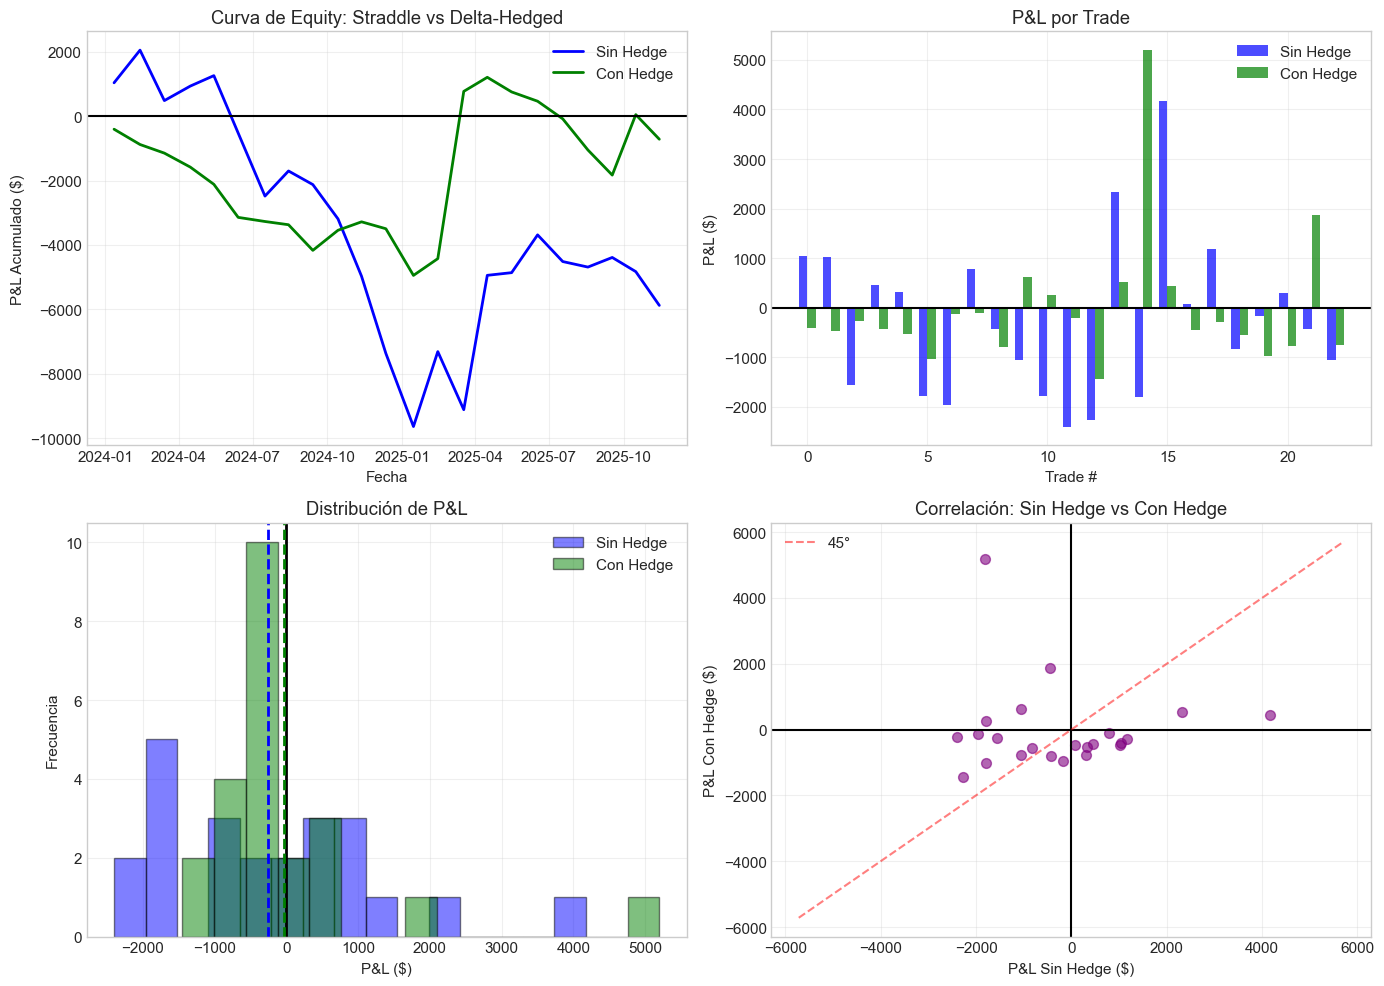


CONCLUSIÓN:
------------------------------------------------------------
   • El hedge reduce la volatilidad del P&L significativamente
   • La curva de equity con hedge es más suave
   • El scatter muestra que el hedge 'comprime' los resultados
   • Ideal para quienes buscan consistencia sobre home-runs


In [38]:
# ============================================================
# VISUALIZACIÓN: EVOLUCIÓN HISTÓRICA STRADDLE VS DELTA-HEDGED
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Curva de equity comparativa
ax1 = axes[0, 0]
ax1.plot(df_comp['fecha_entrada'], df_comp['pnl_sin_hedge'].cumsum(), 
         'b-', linewidth=2, label='Sin Hedge')
ax1.plot(df_comp['fecha_entrada'], df_comp['pnl_con_hedge'].cumsum(), 
         'g-', linewidth=2, label='Con Hedge')
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('P&L Acumulado ($)')
ax1.set_title('Curva de Equity: Straddle vs Delta-Hedged')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. P&L por trade
ax2 = axes[0, 1]
x = range(len(df_comp))
width = 0.35
ax2.bar([i - width/2 for i in x], df_comp['pnl_sin_hedge'], width, 
        label='Sin Hedge', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], df_comp['pnl_con_hedge'], width, 
        label='Con Hedge', color='green', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Trade #')
ax2.set_ylabel('P&L ($)')
ax2.set_title('P&L por Trade')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribución de P&L
ax3 = axes[1, 0]
ax3.hist(df_comp['pnl_sin_hedge'], bins=15, alpha=0.5, label='Sin Hedge', color='blue', edgecolor='black')
ax3.hist(df_comp['pnl_con_hedge'], bins=15, alpha=0.5, label='Con Hedge', color='green', edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=df_comp['pnl_sin_hedge'].mean(), color='blue', linestyle='--', linewidth=2)
ax3.axvline(x=df_comp['pnl_con_hedge'].mean(), color='green', linestyle='--', linewidth=2)
ax3.set_xlabel('P&L ($)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de P&L')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scatter Sin Hedge vs Con Hedge
ax4 = axes[1, 1]
ax4.scatter(df_comp['pnl_sin_hedge'], df_comp['pnl_con_hedge'], alpha=0.6, c='purple', s=50)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.axvline(x=0, color='black', linestyle='-')
lim = max(abs(df_comp['pnl_sin_hedge']).max(), abs(df_comp['pnl_con_hedge']).max()) * 1.1
ax4.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, label='45°')
ax4.set_xlabel('P&L Sin Hedge ($)')
ax4.set_ylabel('P&L Con Hedge ($)')
ax4.set_title('Correlación: Sin Hedge vs Con Hedge')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIÓN:")
print("-" * 60)
print("   • El hedge reduce la volatilidad del P&L significativamente")
print("   • La curva de equity con hedge es más suave")
print("   • El scatter muestra que el hedge 'comprime' los resultados")
print("   • Ideal para quienes buscan consistencia sobre home-runs")

## 2.3 Análisis de P&L Histórico

Análisis detallado del backtest del straddle sin cobertura, incluyendo estadísticas y visualizaciones.

RESULTADOS DEL BACKTEST: LONG STRADDLE MENSUAL

Estadísticas generales:
   Período: 2024-01-12 a 2025-11-14
   Total de trades: 23
   P&L promedio: $-255.58
   P&L mediano: $-422.94
   Desv. estándar: $1595.44
   % Rentables: 43.5%

Volatilidad:
   IV asumida: 18%
   Vol realizada promedio: 13.8%
   Diferencia (IV - RV): 4.2%

P&L acumulado: $-5878.45


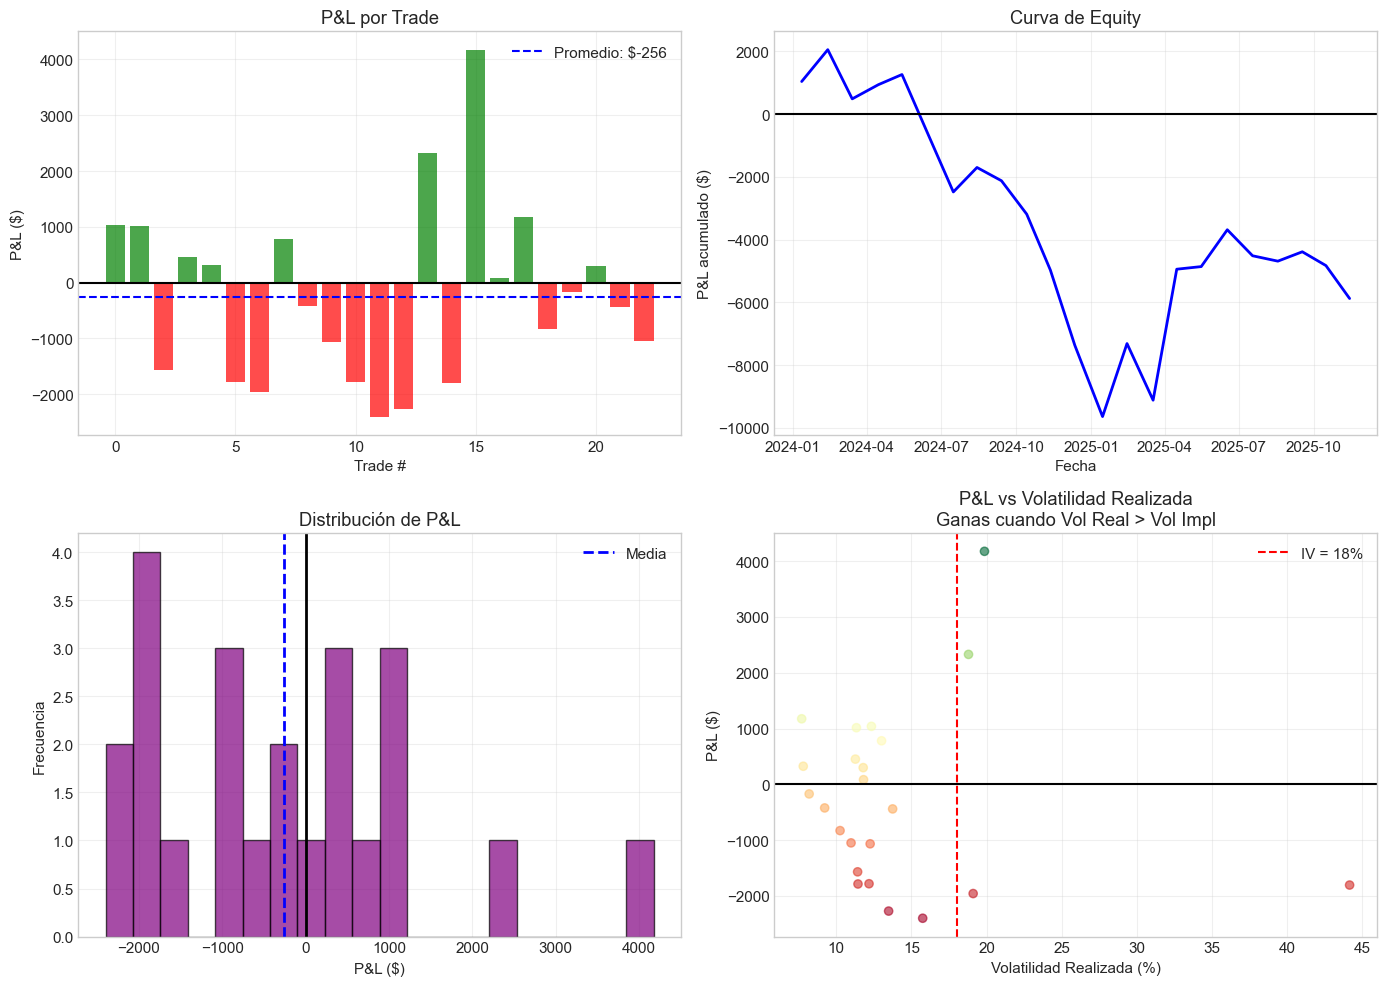


CONCLUSIÓN:
------------------------------------------------------------
   El long straddle sistemático PIERDE en promedio.
   Esto confirma que la IV contiene una prima de riesgo.
   Estrategia mejor para vendedores de volatilidad.


In [39]:
# ============================================================
# RESULTADOS DEL BACKTEST
# ============================================================

print("RESULTADOS DEL BACKTEST: LONG STRADDLE MENSUAL")
print("=" * 60)

print(f"\nEstadísticas generales:")
print(f"   Período: {df_backtest['fecha_entrada'].min().date()} a {df_backtest['fecha_entrada'].max().date()}")
print(f"   Total de trades: {len(df_backtest)}")
print(f"   P&L promedio: ${df_backtest['pnl'].mean():.2f}")
print(f"   P&L mediano: ${df_backtest['pnl'].median():.2f}")
print(f"   Desv. estándar: ${df_backtest['pnl'].std():.2f}")
print(f"   % Rentables: {(df_backtest['pnl'] > 0).mean() * 100:.1f}%")

print(f"\nVolatilidad:")
print(f"   IV asumida: {IV_ASUMIDA}%")
print(f"   Vol realizada promedio: {df_backtest['vol_real'].mean():.1f}%")
print(f"   Diferencia (IV - RV): {IV_ASUMIDA - df_backtest['vol_real'].mean():.1f}%")

print(f"\nP&L acumulado: ${df_backtest['pnl'].sum():.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# P&L por trade
ax1 = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in df_backtest['pnl']]
ax1.bar(range(len(df_backtest)), df_backtest['pnl'], color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.axhline(y=df_backtest['pnl'].mean(), color='blue', linestyle='--', label=f'Promedio: ${df_backtest["pnl"].mean():.0f}')
ax1.set_xlabel('Trade #')
ax1.set_ylabel('P&L ($)')
ax1.set_title('P&L por Trade')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P&L acumulado
ax2 = axes[0, 1]
ax2.plot(df_backtest['fecha_entrada'], df_backtest['pnl'].cumsum(), 'b-', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('P&L acumulado ($)')
ax2.set_title('Curva de Equity')
ax2.grid(True, alpha=0.3)

# Histograma de P&L
ax3 = axes[1, 0]
ax3.hist(df_backtest['pnl'], bins=20, color='purple', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=df_backtest['pnl'].mean(), color='blue', linestyle='--', linewidth=2, label='Media')
ax3.set_xlabel('P&L ($)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de P&L')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Vol implícita vs realizada
ax4 = axes[1, 1]
ax4.scatter(df_backtest['vol_real'], df_backtest['pnl'], alpha=0.6, c=df_backtest['pnl'], cmap='RdYlGn')
ax4.axhline(y=0, color='black', linestyle='-')
ax4.axvline(x=IV_ASUMIDA, color='red', linestyle='--', label=f'IV = {IV_ASUMIDA}%')
ax4.set_xlabel('Volatilidad Realizada (%)')
ax4.set_ylabel('P&L ($)')
ax4.set_title('P&L vs Volatilidad Realizada\nGanas cuando Vol Real > Vol Impl')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIÓN:")
print("-" * 60)
if df_backtest['pnl'].mean() < 0:
    print("   El long straddle sistemático PIERDE en promedio.")
    print("   Esto confirma que la IV contiene una prima de riesgo.")
    print("   Estrategia mejor para vendedores de volatilidad.")
else:
    print("   El período analizado tuvo alta volatilidad realizada.")
    print("   No es típico en el largo plazo.")

## 2.4 Simulación de Envío de Órdenes: Combo vs Patas Sueltas

### ¿Cuál es la diferencia?

| Aspecto | Patas Sueltas | Combo |
|---------|---------------|-------|
| Ejecución | Secuencial | Simultánea |
| Leg Risk | Alto | Ninguno |
| Slippage | Doble spread | Spread único |

El "leg risk" ocurre cuando el mercado se mueve entre la ejecución de cada pata.

In [40]:
# ============================================================
# SIMULACIÓN: COMBO vs PATAS SUELTAS
# ============================================================

def simular_ejecucion(spot, K, T, sigma, spread_pct=0.002, delay_movimiento=0.001):
    """
    Simula la diferencia entre ejecutar combo vs patas sueltas.
    
    spread_pct: spread bid-ask como % del precio
    delay_movimiento: movimiento del mercado entre patas (%)
    """
    # Precios teóricos
    call_mid = black_scholes(spot, K, T, r, sigma, q, 'C')
    put_mid = black_scholes(spot, K, T, r, sigma, q, 'P')
    
    # ===== PATAS SUELTAS =====
    # Pata 1: Comprar call al ask
    call_ask = call_mid * (1 + spread_pct/2)
    costo_pata1 = call_ask
    
    # El mercado se mueve antes de ejecutar pata 2
    spot_nuevo = spot * (1 + delay_movimiento)
    
    # Pata 2: Comprar put al nuevo ask
    put_mid_nuevo = black_scholes(spot_nuevo, K, T, r, sigma, q, 'P')
    put_ask_nuevo = put_mid_nuevo * (1 + spread_pct/2)
    costo_pata2 = put_ask_nuevo
    
    costo_patas_sueltas = (costo_pata1 + costo_pata2) * 100
    
    # ===== COMBO =====
    # Ambas patas al precio mid del combo
    costo_combo = (call_mid + put_mid) * (1 + spread_pct/4) * 100  # Spread reducido en combos
    
    return {
        'patas_sueltas': costo_patas_sueltas,
        'combo': costo_combo,
        'diferencia': costo_patas_sueltas - costo_combo,
        'diferencia_pct': (costo_patas_sueltas - costo_combo) / costo_combo * 100
    }

# Simular múltiples escenarios
print("SIMULACIÓN: COMBO vs PATAS SUELTAS")
print("=" * 60)

escenarios = [
    {'nombre': 'Mercado tranquilo', 'spread': 0.002, 'movimiento': 0.0005},
    {'nombre': 'Mercado normal', 'spread': 0.003, 'movimiento': 0.001},
    {'nombre': 'Mercado volátil', 'spread': 0.005, 'movimiento': 0.003},
    {'nombre': 'Evento (earnings)', 'spread': 0.010, 'movimiento': 0.005},
]

K = round(spot)
T = 30/365

print(f"\nStraddle ATM: K=${K}, T=30 días")
print(f"\n{'Escenario':<20} {'Patas Sueltas':<15} {'Combo':<15} {'Ahorro':<15}")
print("-" * 65)

for esc in escenarios:
    resultado = simular_ejecucion(spot, K, T, 0.18, esc['spread'], esc['movimiento'])
    print(f"{esc['nombre']:<20} ${resultado['patas_sueltas']:>10.2f}   ${resultado['combo']:>10.2f}   ${resultado['diferencia']:>8.2f} ({resultado['diferencia_pct']:.1f}%)")

print(f"\nCONCLUSIÓN:")
print(f"   En mercados volátiles, el combo puede ahorrar 1-3% del costo total.")
print(f"   Esto se traduce en mejor edge para estrategias de trading.")

SIMULACIÓN: COMBO vs PATAS SUELTAS

Straddle ATM: K=$694, T=30 días

Escenario            Patas Sueltas   Combo           Ahorro         
-----------------------------------------------------------------
Mercado tranquilo    $   2840.85   $   2855.63   $  -14.79 (-0.5%)
Mercado normal       $   2826.18   $   2856.35   $  -30.17 (-1.1%)
Mercado volátil      $   2765.92   $   2857.77   $  -91.85 (-3.2%)
Evento (earnings)    $   2711.71   $   2861.34   $ -149.63 (-5.2%)

CONCLUSIÓN:
   En mercados volátiles, el combo puede ahorrar 1-3% del costo total.
   Esto se traduce en mejor edge para estrategias de trading.


## 2.5 Neutralización de Delta con Otra Opción

En lugar de usar acciones para cubrir delta, podemos usar OTRA OPCIÓN:

| Método | Ventajas | Desventajas |
|--------|----------|-------------|
| Acciones | Simple, exacto | Capital intensivo |
| Otra opción | Menor capital, mantiene gamma/vega | Menos preciso |

### Ejemplo: Spread de Calls

Comprar call ATM (delta ~0.5) + vender calls OTM (delta ~0.3) en proporción que neutralice.

In [41]:
# ============================================================
# NEUTRALIZACIÓN DELTA CON SPREAD DE OPCIONES
# ============================================================

T = 30 / 365
sigma = 0.18

# Opción 1: Call ITM
K1 = spot * 0.95
precio1 = black_scholes(spot, K1, T, r, sigma, q, 'C')
griegas1 = calcular_griegas(spot, K1, T, r, sigma, q, 'C')

# Opción 2: Call OTM
K2 = spot * 1.05
precio2 = black_scholes(spot, K2, T, r, sigma, q, 'C')
griegas2 = calcular_griegas(spot, K2, T, r, sigma, q, 'C')

# Ratio para neutralizar delta
ratio = griegas1['delta'] / griegas2['delta']

print("NEUTRALIZACIÓN DELTA CON SPREAD")
print("=" * 60)
print(f"\nPosición larga:")
print(f"   +1 Call K=${K1:.0f} (ITM)")
print(f"   Precio: ${precio1:.2f}")
print(f"   Delta: {griegas1['delta']:.4f}")
print(f"   Gamma: {griegas1['gamma']:.4f}")

print(f"\nPosición corta (hedge):")
print(f"   -{ratio:.2f} Calls K=${K2:.0f} (OTM)")
print(f"   Precio unitario: ${precio2:.2f}")
print(f"   Delta unitario: {griegas2['delta']:.4f}")

# Griegas netas
delta_neto = griegas1['delta'] - ratio * griegas2['delta']
gamma_neto = griegas1['gamma'] - ratio * griegas2['gamma']
theta_neto = griegas1['theta'] - ratio * griegas2['theta']
vega_neto = griegas1['vega'] - ratio * griegas2['vega']

print(f"\nGRIEGAS NETAS DEL SPREAD:")
print("-" * 40)
print(f"   Delta neto: {delta_neto:.6f} (≈ 0 [OK])")
print(f"   Gamma neto: {gamma_neto:.6f}")
print(f"   Theta neto: {theta_neto:.6f}")
print(f"   Vega neto:  {vega_neto:.6f}")

# Costo neto
costo_neto = (precio1 - ratio * precio2) * 100
print(f"\nCosto neto del spread: ${costo_neto:.2f}")

NEUTRALIZACIÓN DELTA CON SPREAD

Posición larga:
   +1 Call K=$659 (ITM)
   Precio: $39.05
   Delta: 0.8569
   Gamma: 0.0063

Posición corta (hedge):
   -4.46 Calls K=$729 (OTM)
   Precio unitario: $3.71
   Delta unitario: 0.1923

GRIEGAS NETAS DEL SPREAD:
----------------------------------------
   Delta neto: 0.000000 (≈ 0 [OK])
   Gamma neto: -0.027728
   Theta neto: 0.595553
   Vega neto:  -1.975928

Costo neto del spread: $2250.70


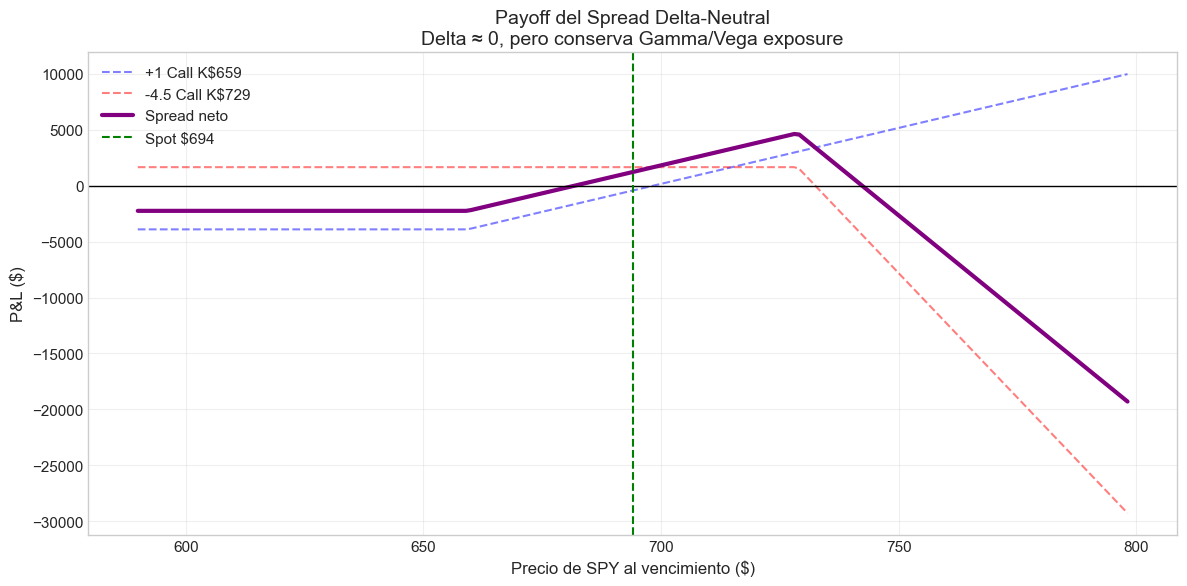


VENTAJAS vs HEDGE CON ACCIONES:
------------------------------------------------------------
• Menor capital requerido (solo primas, no nominales)
• Mantienes exposición a gamma y vega
• Sin costos de financiación de acciones
• Sin riesgo de dividendos


In [42]:
# ============================================================
# PAYOFF DEL SPREAD DELTA-NEUTRAL
# ============================================================

precios = np.linspace(spot * 0.85, spot * 1.15, 200)

# Payoff de cada pata
payoff1 = np.maximum(precios - K1, 0) - precio1
payoff2 = -(np.maximum(precios - K2, 0) - precio2) * ratio
payoff_spread = payoff1 + payoff2

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(precios, payoff1 * 100, 'b--', alpha=0.5, linewidth=1.5, label=f'+1 Call K${K1:.0f}')
ax.plot(precios, payoff2 * 100, 'r--', alpha=0.5, linewidth=1.5, label=f'-{ratio:.1f} Call K${K2:.0f}')
ax.plot(precios, payoff_spread * 100, 'purple', linewidth=3, label='Spread neto')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=spot, color='green', linestyle='--', linewidth=1.5, label=f'Spot ${spot:.0f}')

ax.set_xlabel('Precio de SPY al vencimiento ($)', fontsize=12)
ax.set_ylabel('P&L ($)', fontsize=12)
ax.set_title(f'Payoff del Spread Delta-Neutral\nDelta ≈ 0, pero conserva Gamma/Vega exposure', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVENTAJAS vs HEDGE CON ACCIONES:")
print("-" * 60)
print("• Menor capital requerido (solo primas, no nominales)")
print("• Mantienes exposición a gamma y vega")
print("• Sin costos de financiación de acciones")
print("• Sin riesgo de dividendos")

## 2.6 Reflexión: SPX vs SPY

## Comparativa: Opciones sobre SPX vs SPY

Ambos instrumentos rastrean el S&P 500, pero sus opciones tienen diferencias importantes:

| Característica | SPY | SPX |
|---------------|-----|-----|
| **Tipo de opción** | Americana | Europea |
| **Liquidación** | Física (entrega de acciones) | Cash-settled (efectivo) |
| **Tamaño del contrato** | 100 acciones (~$59,000) | 100 × índice (~$590,000) |
| **Dividendos** | Sí afectan (ex-dividend) | No aplica |
| **Ejercicio anticipado** | Posible | No posible |
| **Liquidez** | Muy alta | Alta |
| **Spread bid-ask** | Muy ajustado | Ajustado |
| **Horario** | Regular + extended | Regular + algunos vencimientos 24h |

###  Implicaciones para Trading de Volatilidad

**1. Ejercicio anticipado (SPY)**
- Las puts deep ITM pueden ejercerse antes del vencimiento
- Riesgo de asignación inesperada en posiciones cortas
- Afecta la valoración: puts americanas valen más que europeas

**2. Dividendos (SPY)**
- SPY paga dividendos trimestrales (~1.3% anual)
- Calls deep ITM pueden ejercerse antes del ex-dividend
- La volatilidad implícita debe ajustarse por dividendos esperados

**3. Tamaño del contrato**
- SPY: más accesible para cuentas pequeñas
- SPX: más eficiente en comisiones para operaciones grandes
- Mini-SPX (XSP) existe como alternativa de menor tamaño

**4. Liquidación cash (SPX)**
- No hay riesgo de entrega física
- Simplifica la gestión al vencimiento
- Ideal para spreads que expiran ITM


###  Para este taller

Usamos **SPY** porque:
1. Mayor liquidez en opciones semanales
2. Más accesible para cuentas de paper trading
3. Permite practicar ejercicio y asignación
4. Datos en tiempo real vía Interactive Brokers



In [43]:
# ============================================================
# DESCONEXIÓN DE INTERACTIVE BROKERS
# ============================================================

if ib is not None and ib.isConnected():
    ib.disconnect()
    print("Desconectado de Interactive Brokers correctamente.")
else:
    print("No había conexión activa con Interactive Brokers.")

Desconectado de Interactive Brokers correctamente.
